# Using the EXBA tools

This notebook shows how to use the tools available in the EXBA class.
It uses the `lightkurve` package as base.

In [1]:
import os, sys, glob
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import lightkurve as lk

%matplotlib inline
path = os.path.dirname(os.getcwd()) 

sys.path.append(path)
from exba import EXBA, EXBACollection

%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## EXBA object

Create and EXBA object for a given Kepler channel and quarter by combining the 4 TPFs available per channel.

The EXBA object has the following attributes:
* tpfs: A TPFCollection of the original data
* time: an array with the JD of observation
* row: arrays with coordinates in pixel space
* col: arrays with coordinates in pixel space
* ra: arrays with coordinates in world space
* dec: arrays with coordinates in world space
* flux: array with flux values per pixel
* sources: list of (clean) Gaia sources present in the images

In [18]:
exba = EXBA(channel=53, quarter=5)

### Plotting stitched image

<AxesSubplot:xlabel='R.A. [deg]', ylabel='Dec [deg]'>

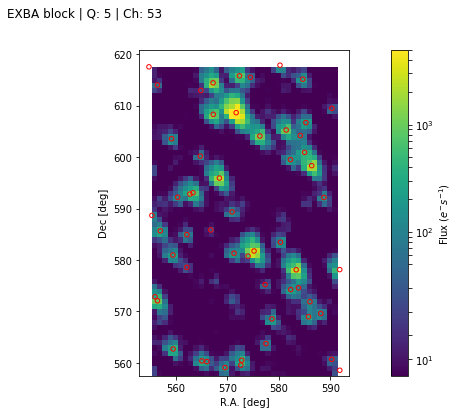

In [19]:
exba.plot_image()

### Compute photometry

This implements a simple square aperture photometry, it creates an object attribute named `self.sap_lcs`, a `lk.LightCurveCollection` object with time series for all Gaia sources.

Each light curve is a `lk.LightCurve` object and inherit all its methods and attributes.

In [22]:
exba.simple_aperture_phot()

Simple SAP flux:   0%|          | 0/4492 [00:00<?, ?it/s]

### Test adaptive aperture

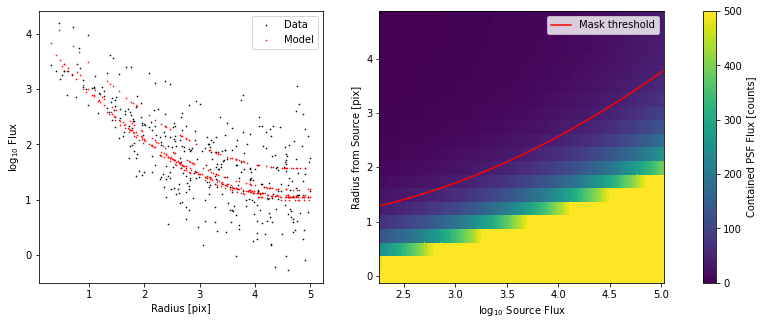

array([1.48593507, 1.81995406, 2.3577453 , 1.48918067, 2.96197211,
       1.72575151, 2.35891625, 1.93509077, 1.68329708, 1.82749054,
       1.46014635, 1.72179817, 1.7065559 , 1.35922989, 1.60578961,
       1.65043311, 1.41350363, 1.70878025, 1.29847991, 2.27906542,
       1.41826073, 2.04058519, 1.30672529, 2.70969704, 1.56006764,
       1.60183717, 1.3699334 , 1.41647185, 1.4854813 , 2.0224614 ,
       1.72321272, 1.76780527, 1.5331224 , 2.40341563, 1.73516666,
       1.60464247, 2.25122211, 2.70767076, 1.63945703, 1.79567689,
       2.75860103, 1.36915329, 2.03804854, 1.53213243, 1.45542417,
       1.54026916, 1.79757972, 1.55244414, 3.76501456, 1.32129019,
       2.30501497, 1.83706919, 2.3988862 , 2.60984987, 1.80686156,
       1.65469969])

In [94]:
exba._find_psf_edge(radius_limit=5, cut=50, plot=True)
exba.radius

In [99]:
exba.simple_aperture_phot(space='pix-auto')

Simple SAP flux:   0%|          | 0/4492 [00:00<?, ?it/s]

## Plotting light curves and stamps

The EXBA object as a method that plot a single or multiple (list of targets) light curves, image data and the used photometric aperture. 

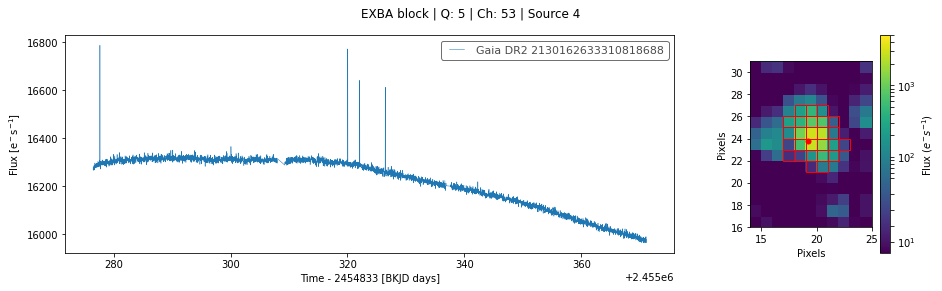

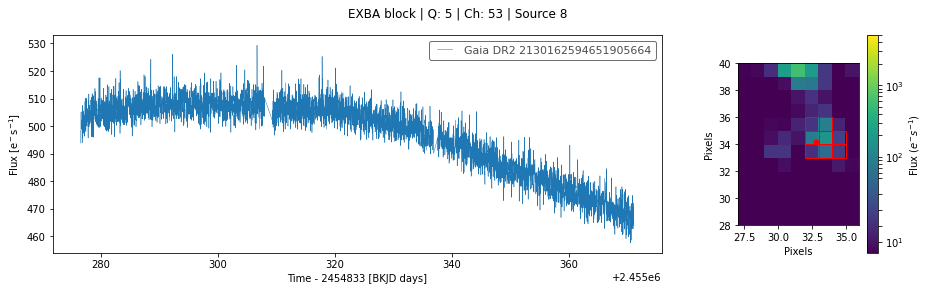

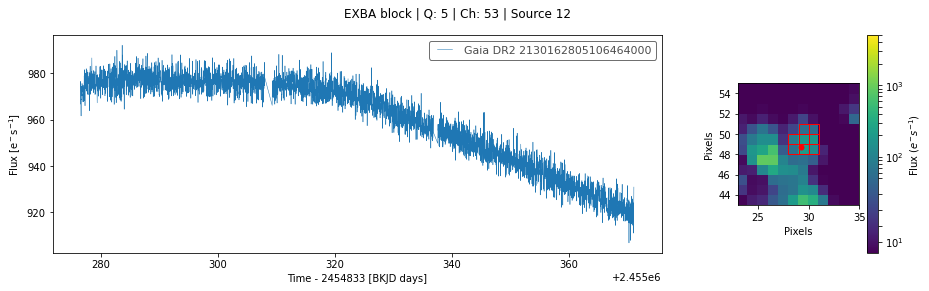

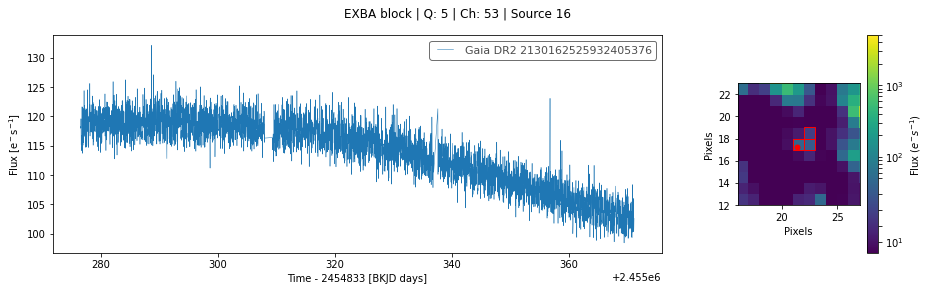

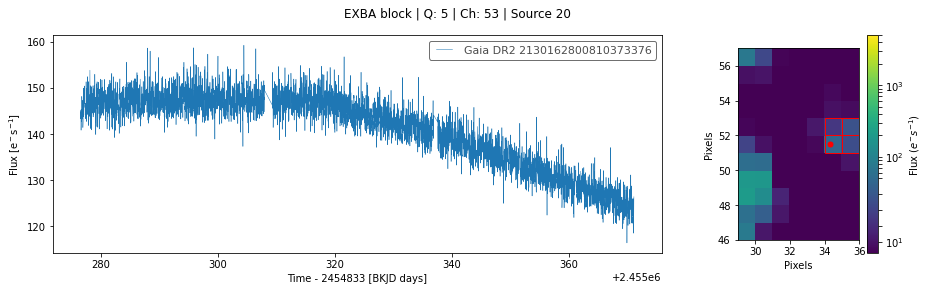

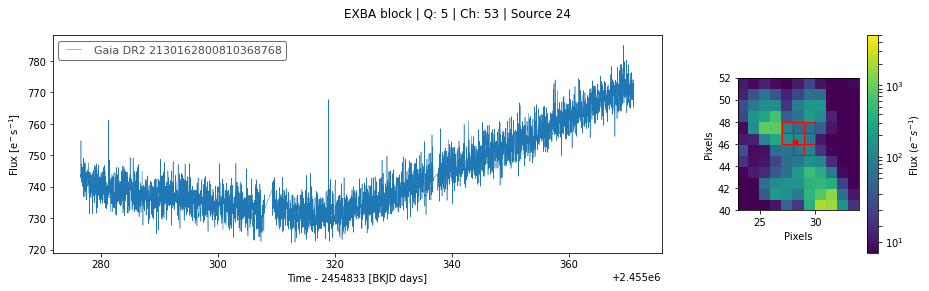

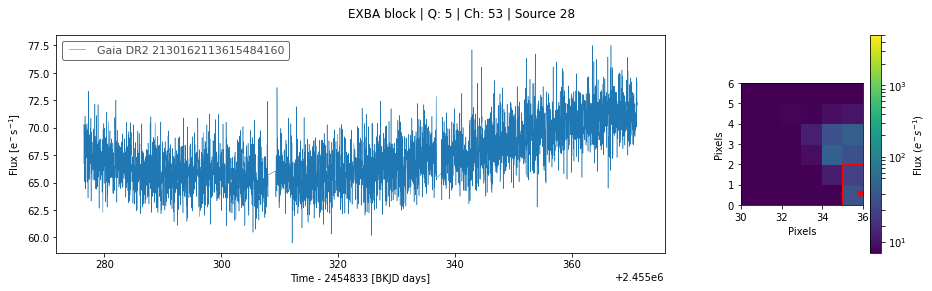

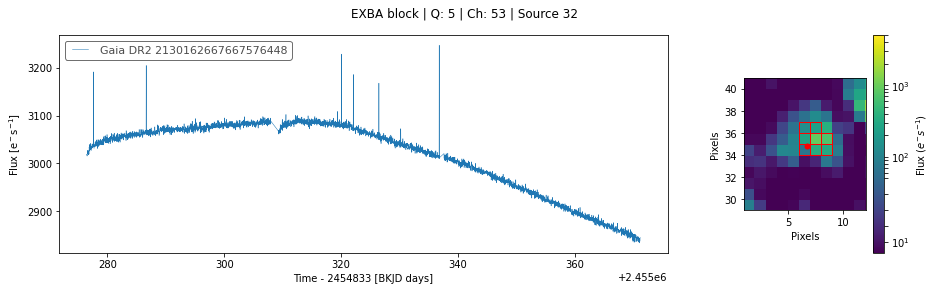

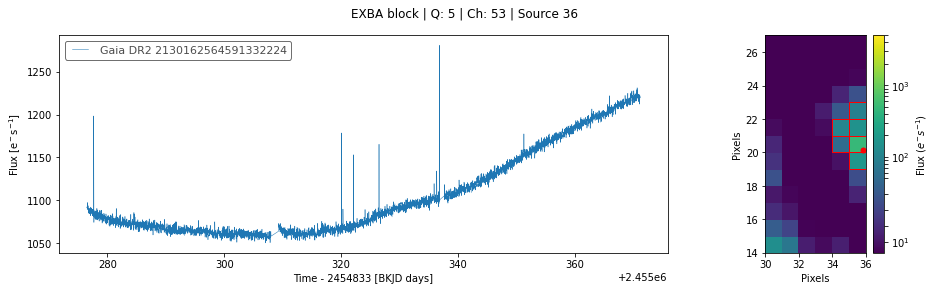

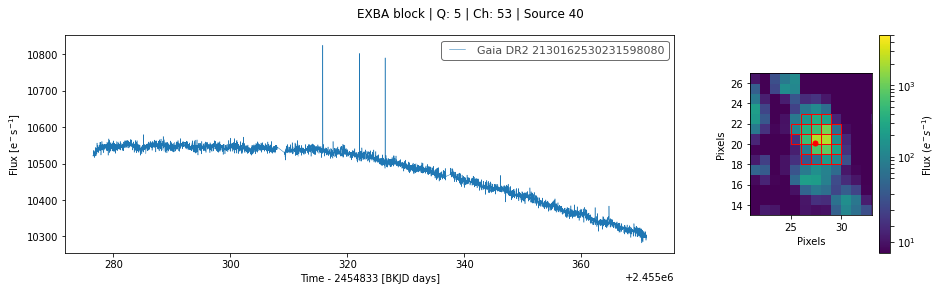

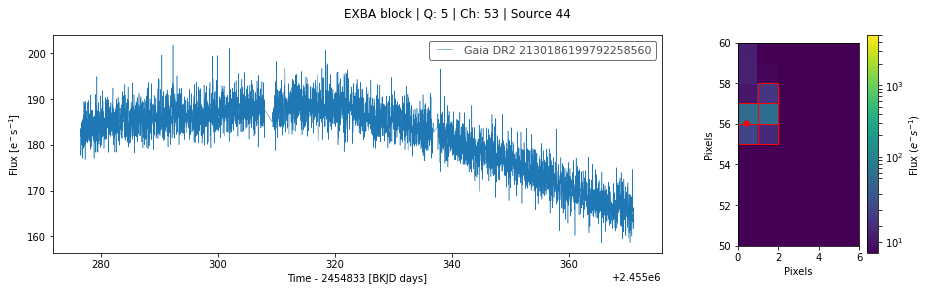

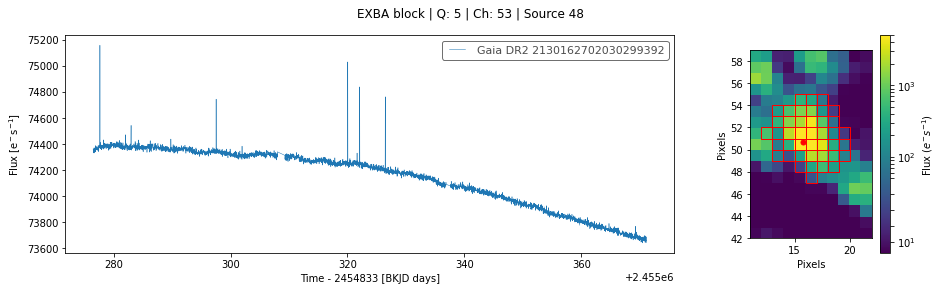

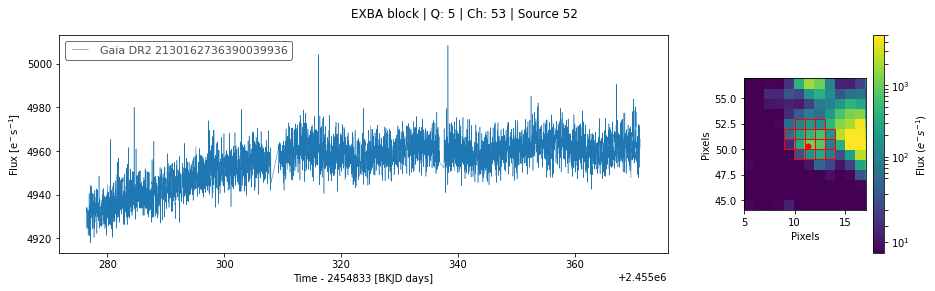

In [100]:
test = ['Gaia DR2 2130161911756323712', 'Gaia DR2 2130161877396580608']
exba.plot_lightcurves(step=4)

### Apply CBV corrector to all light curves

# Explore CBV correction from `lightkurve` 

In [79]:
from lightkurve.correctors import CBVCorrector

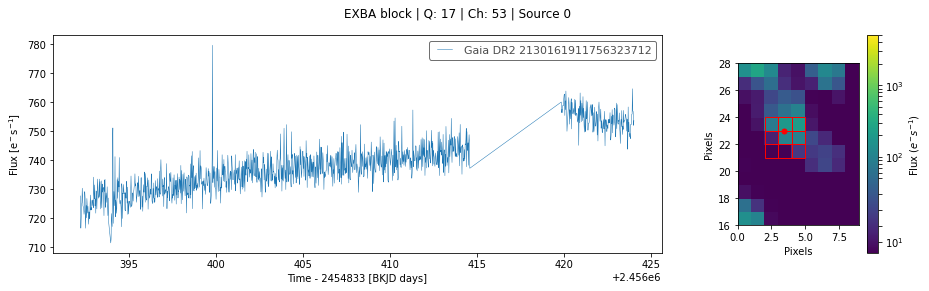

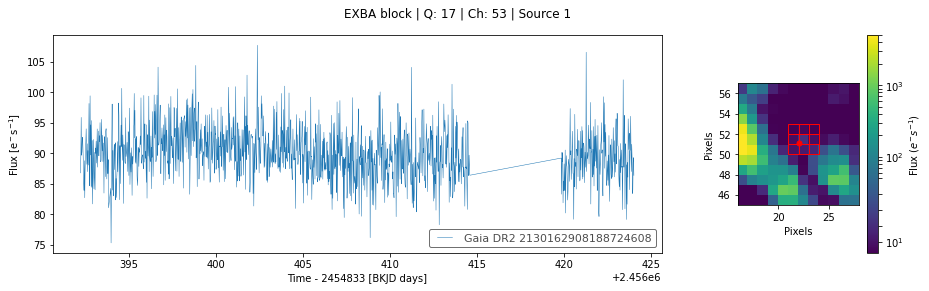

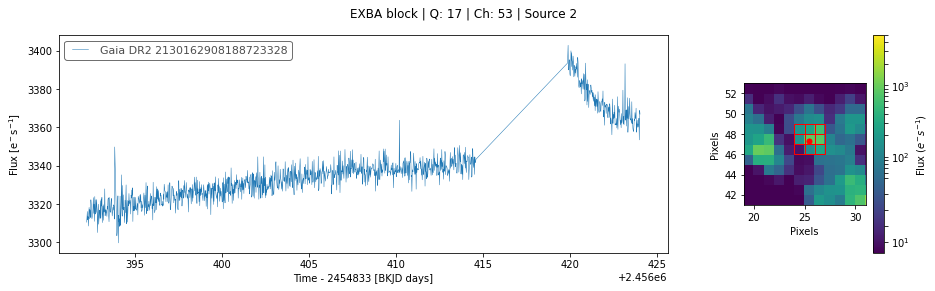

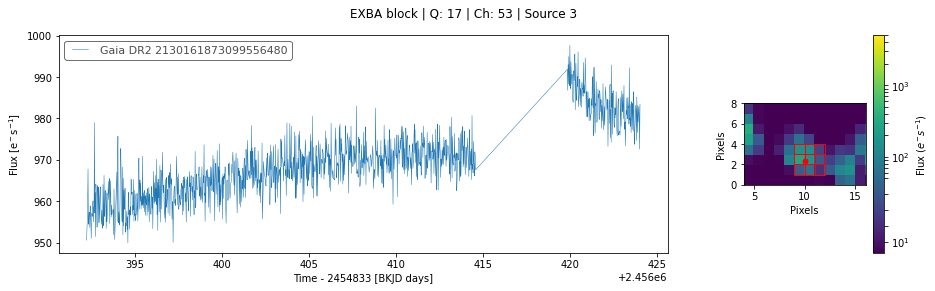

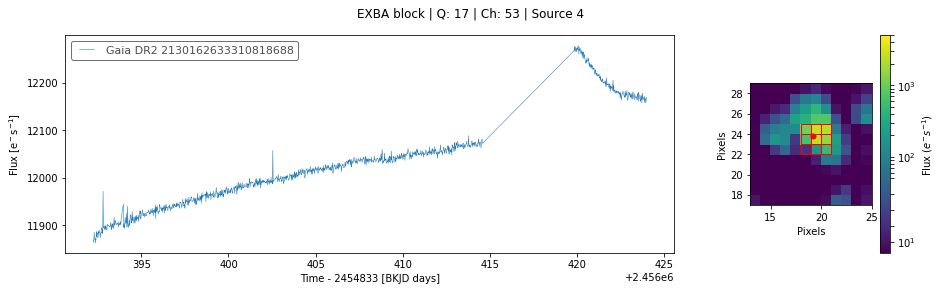

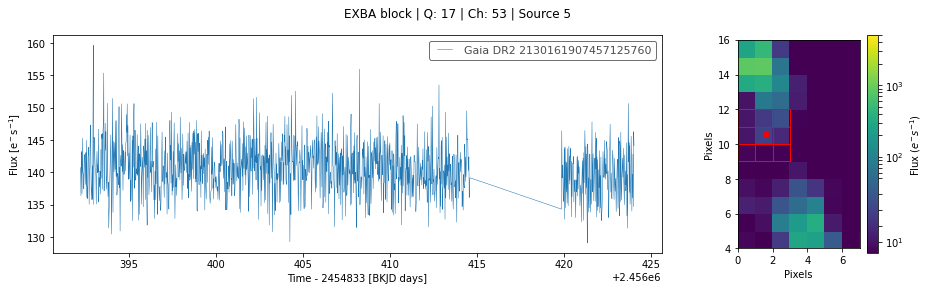

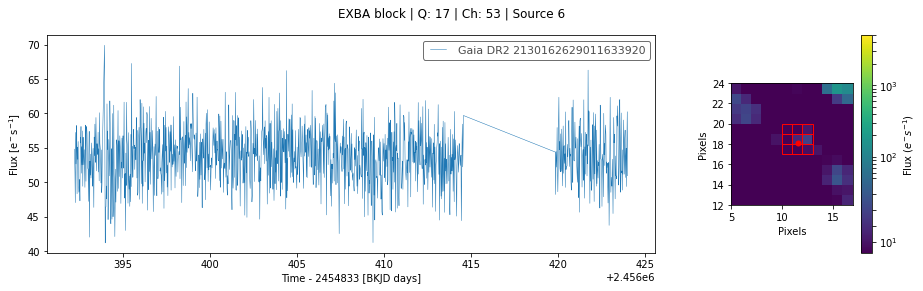

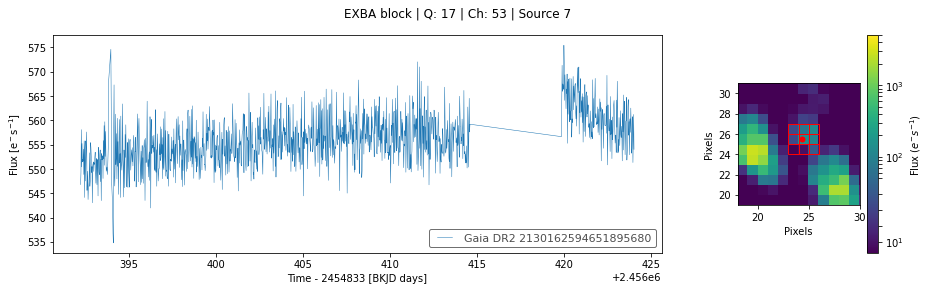

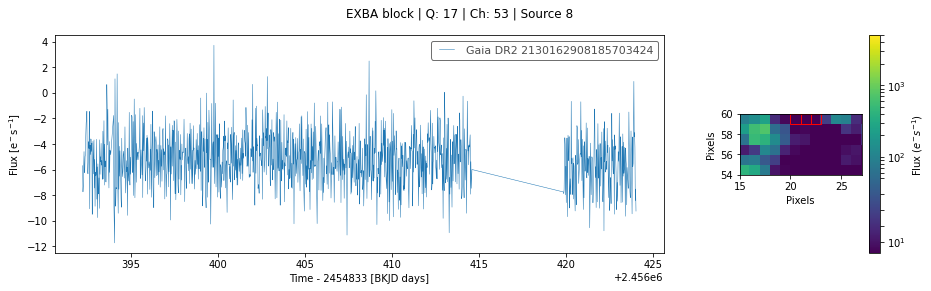

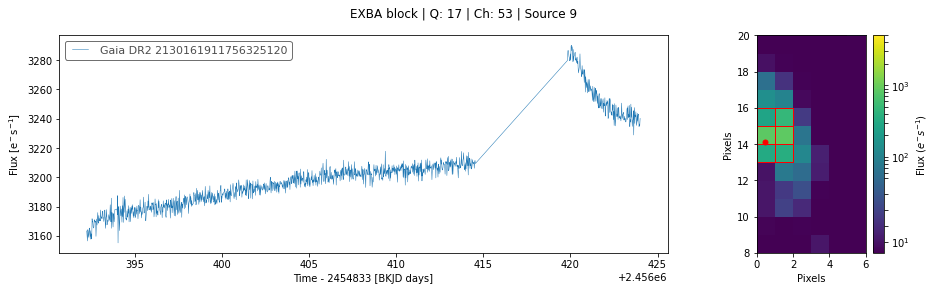

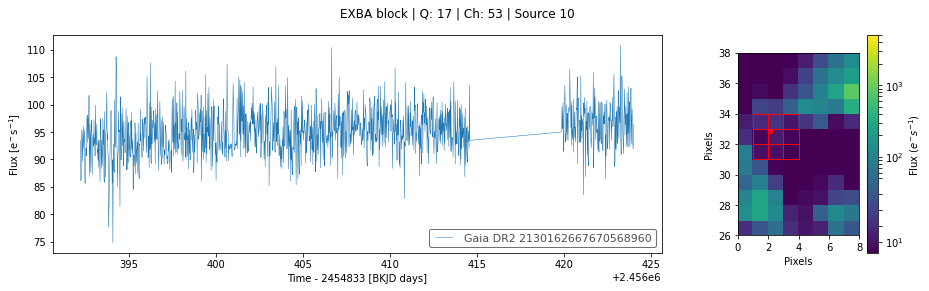

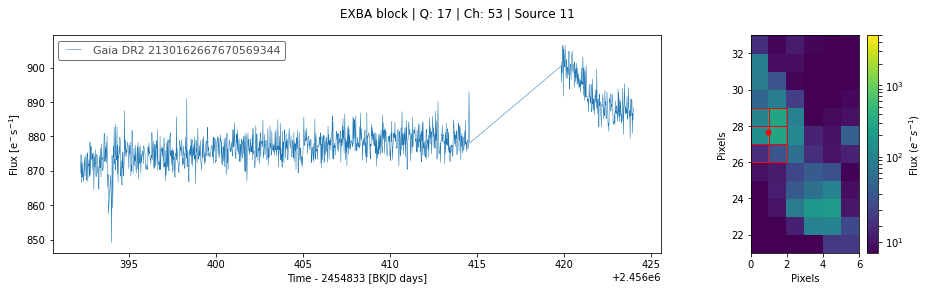

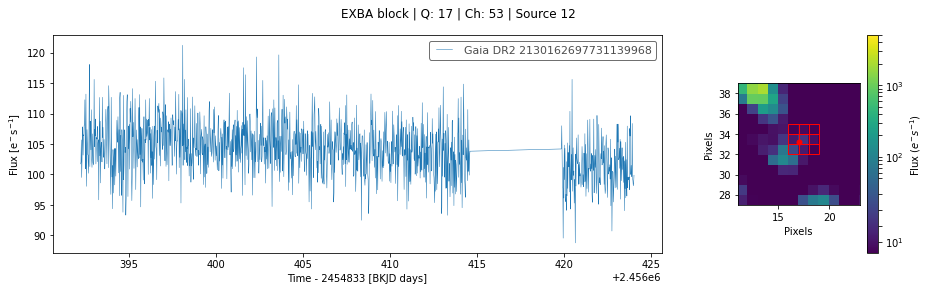

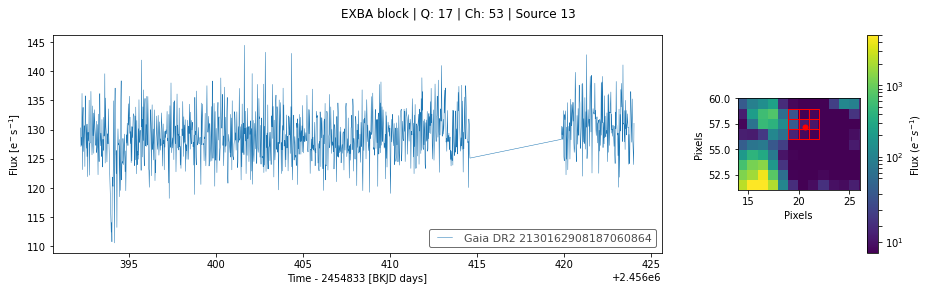

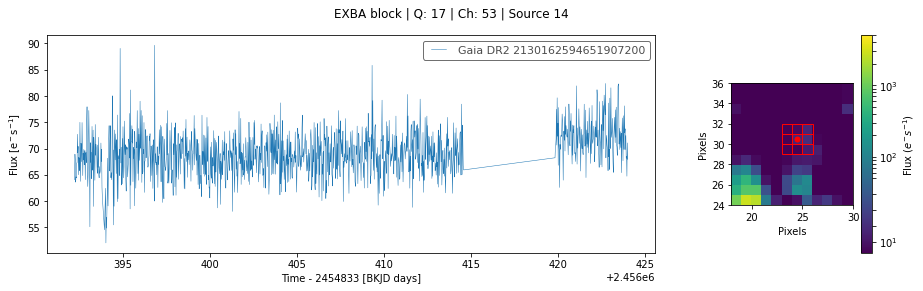

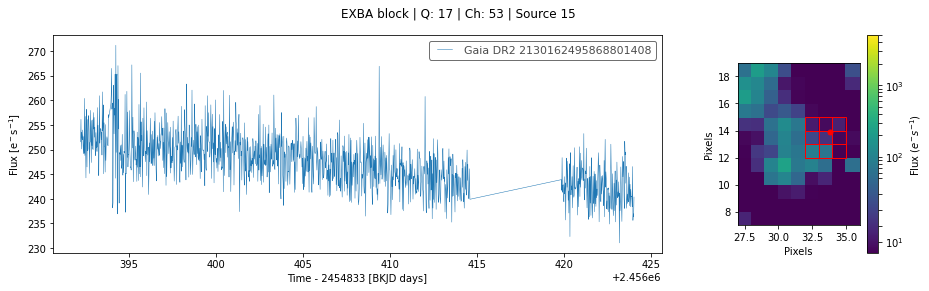

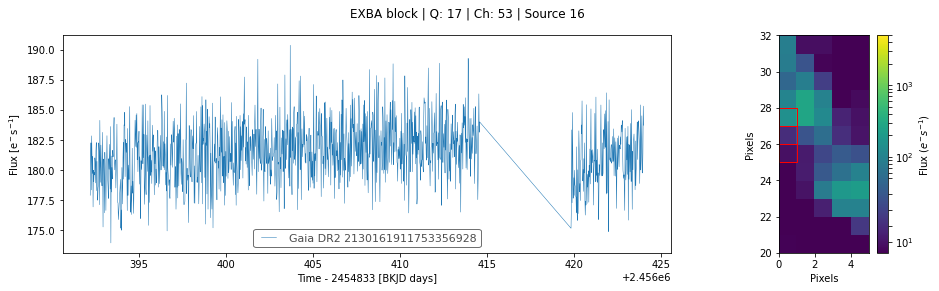

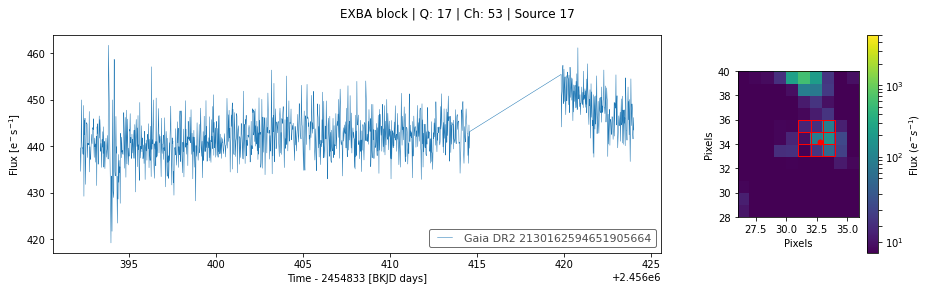

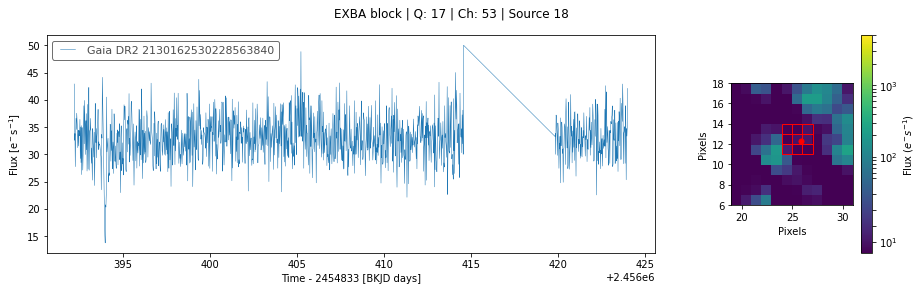

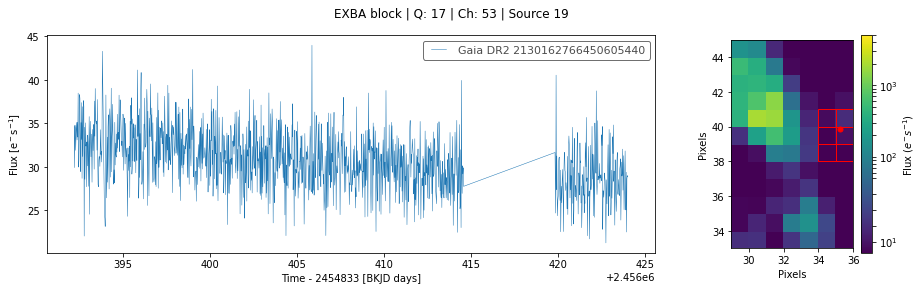

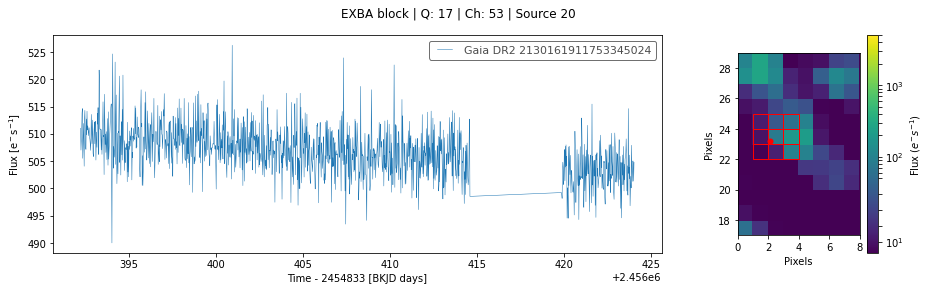

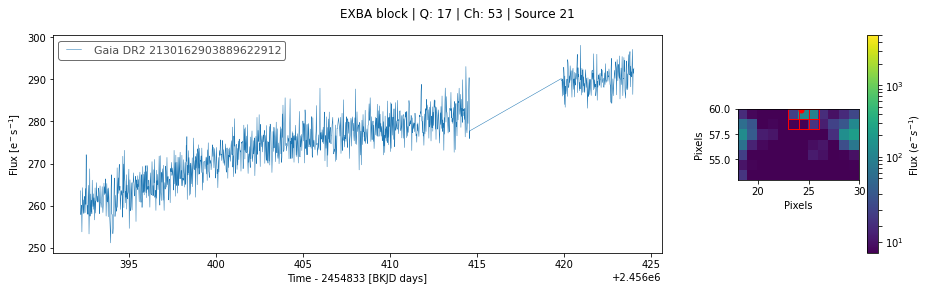

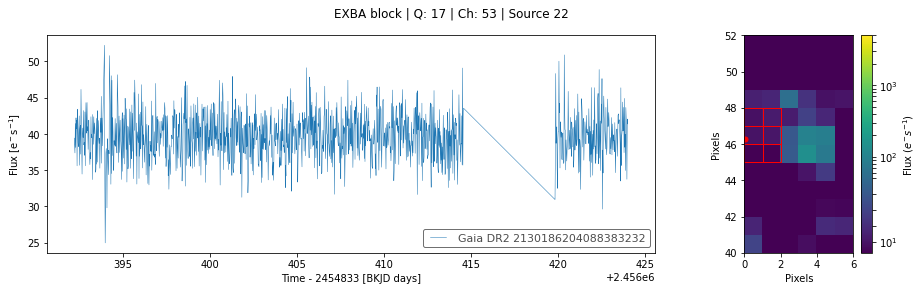

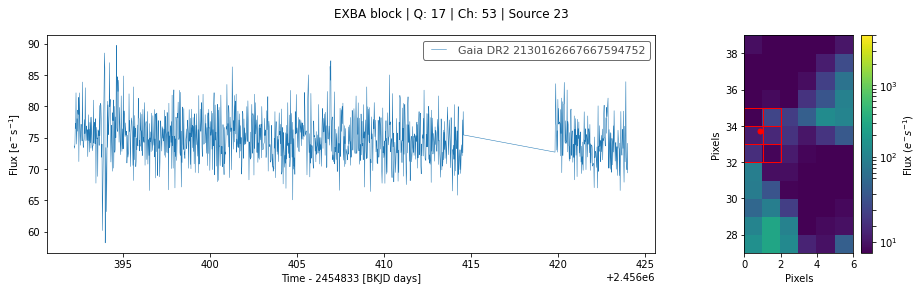

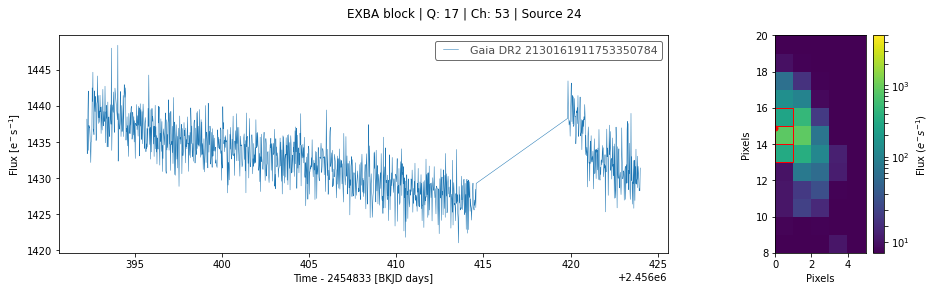

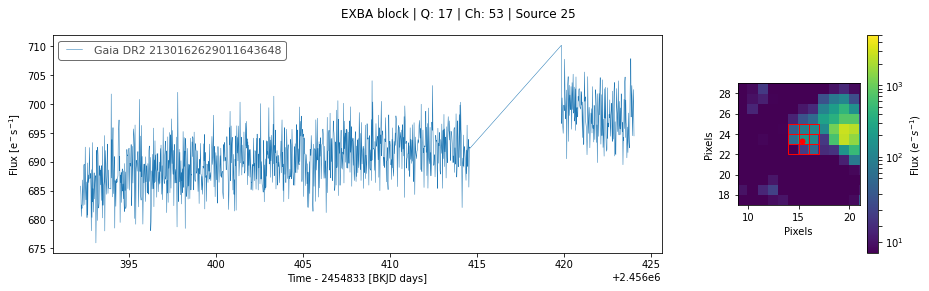

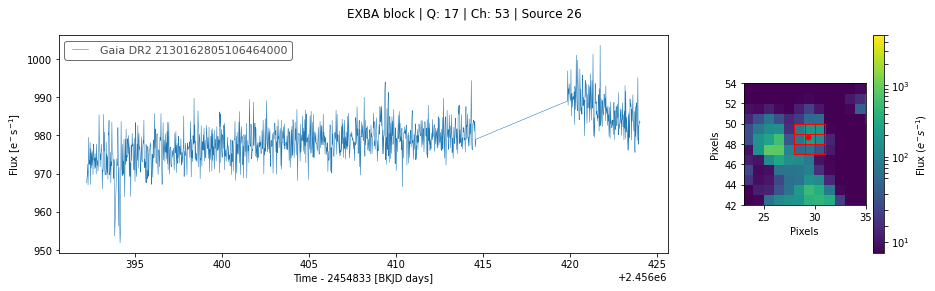

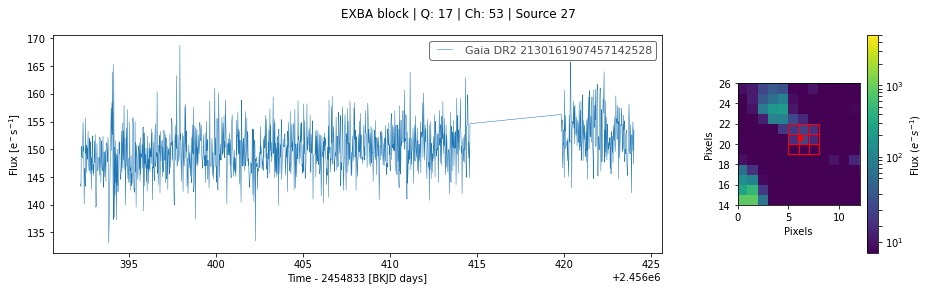

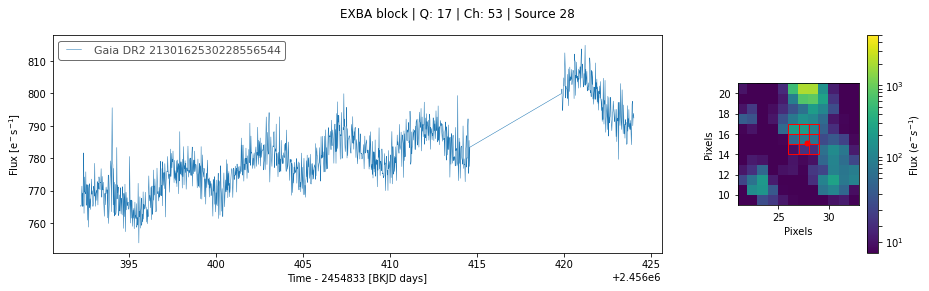

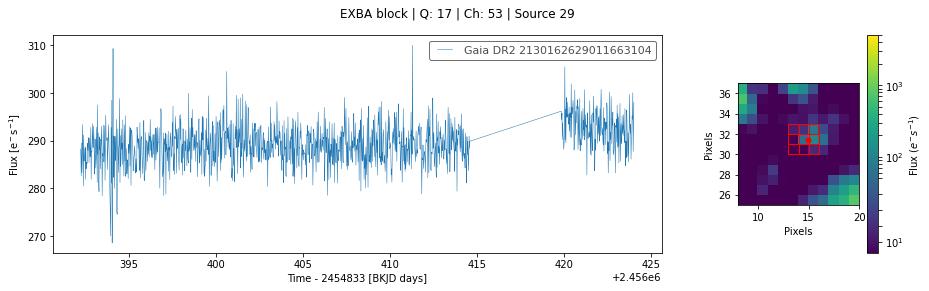

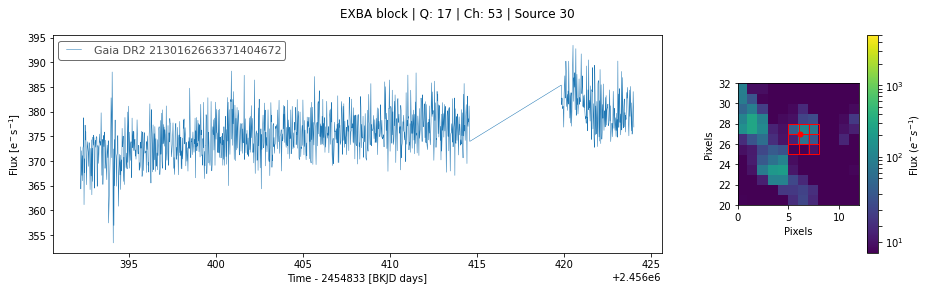

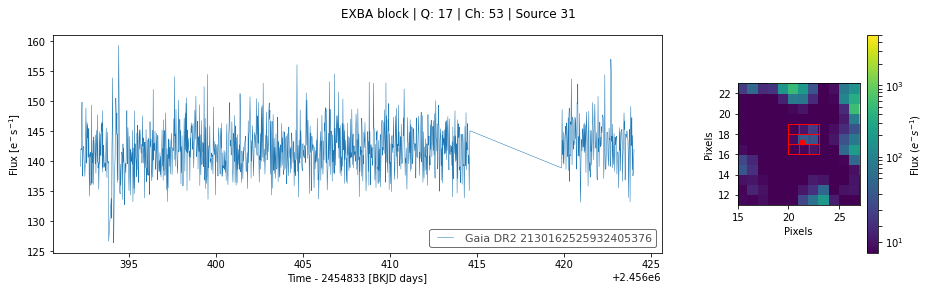

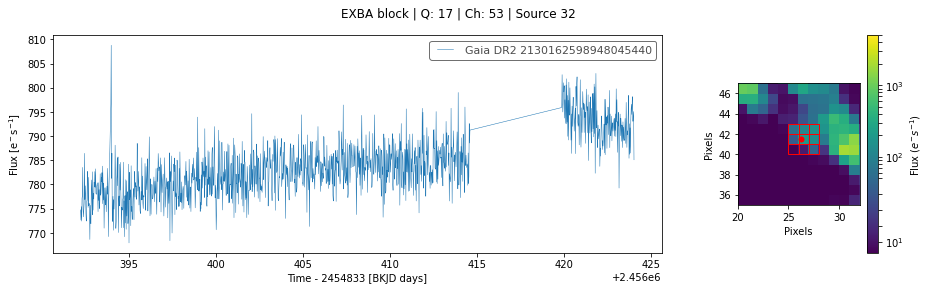

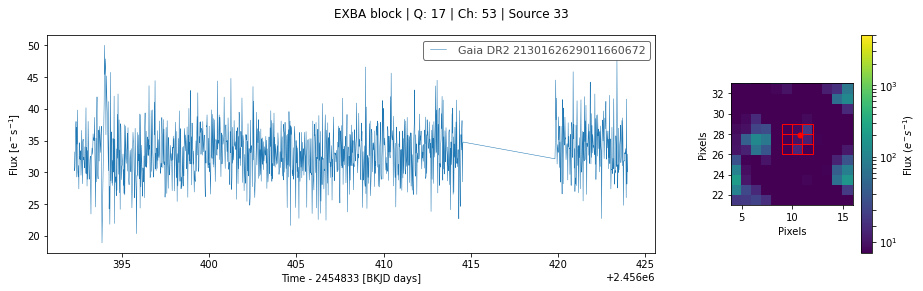

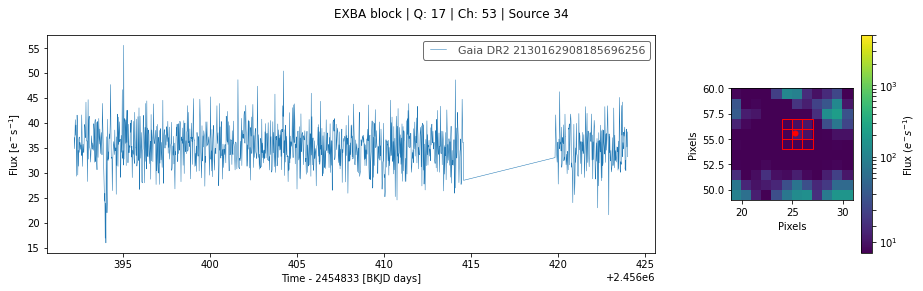

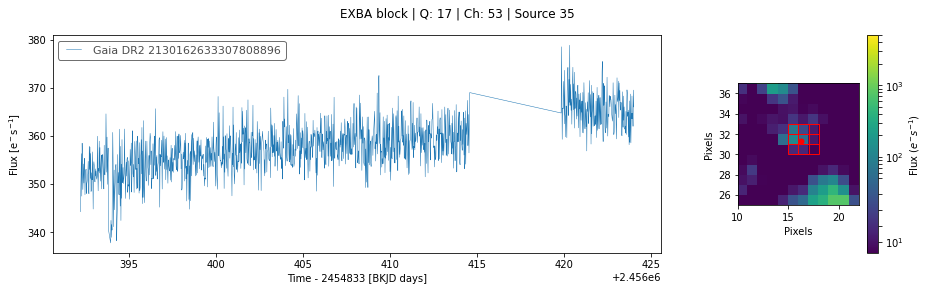

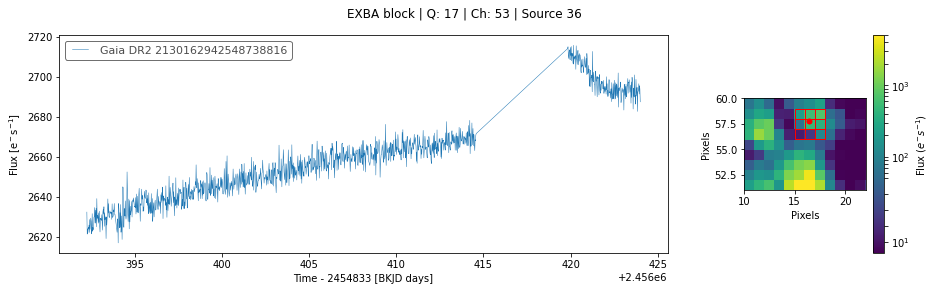

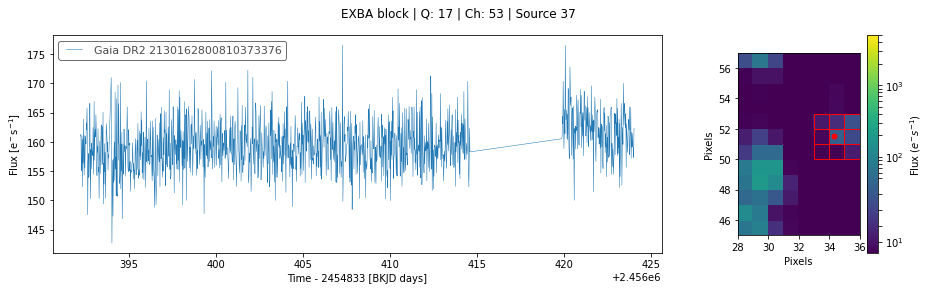

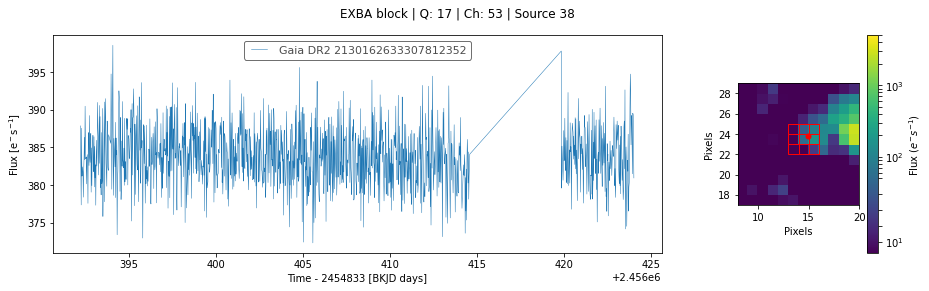

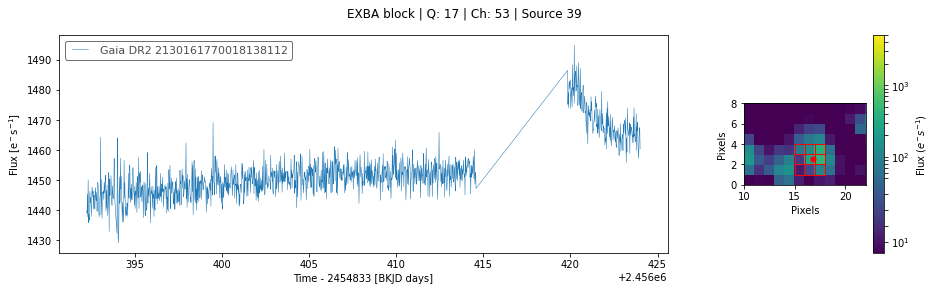

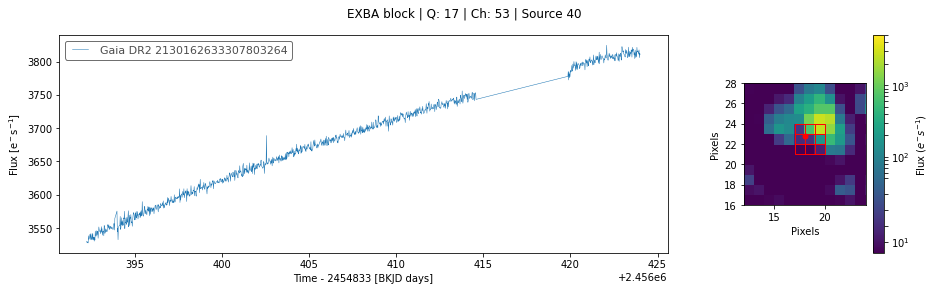

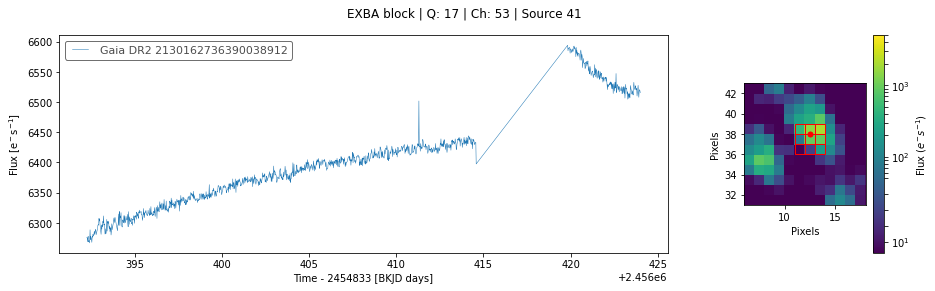

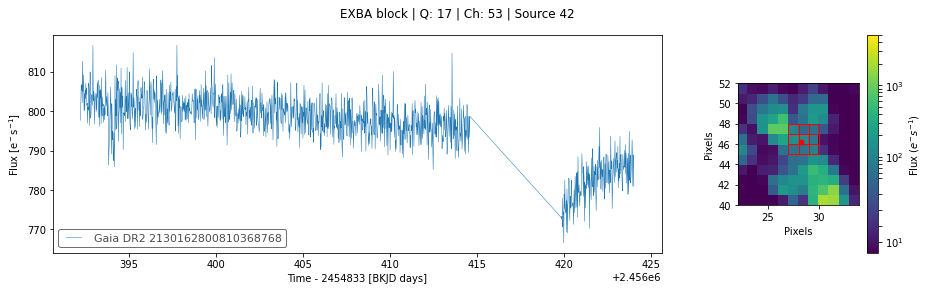

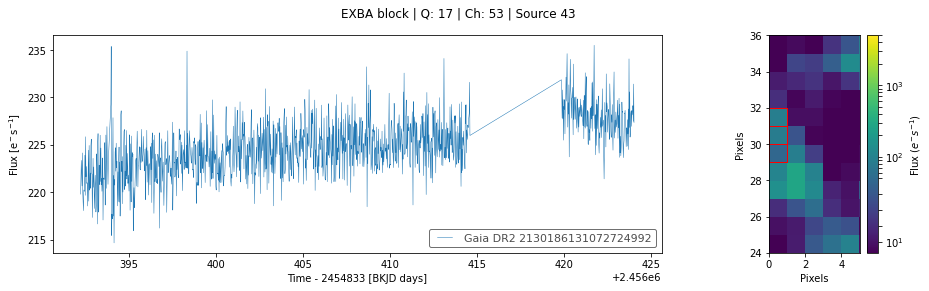

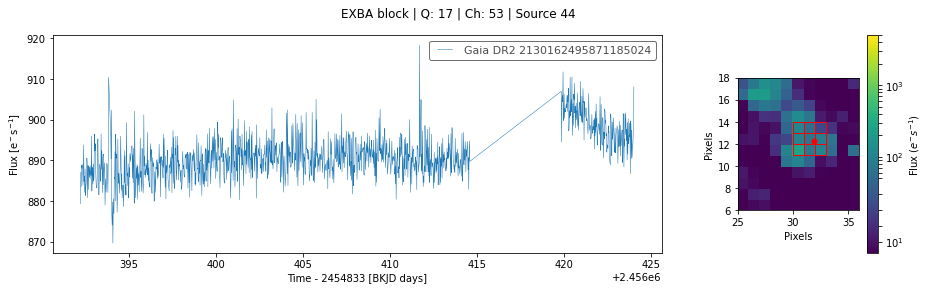

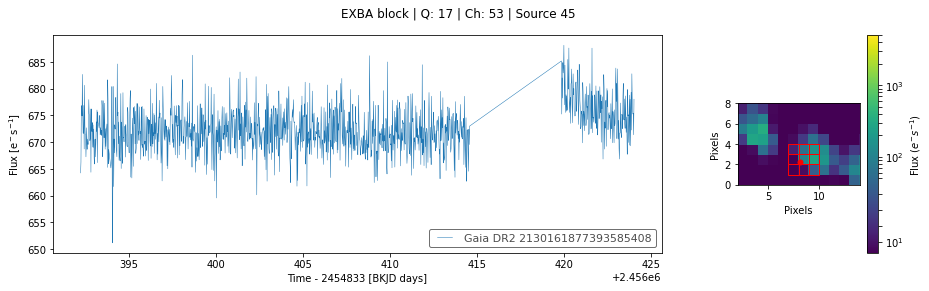

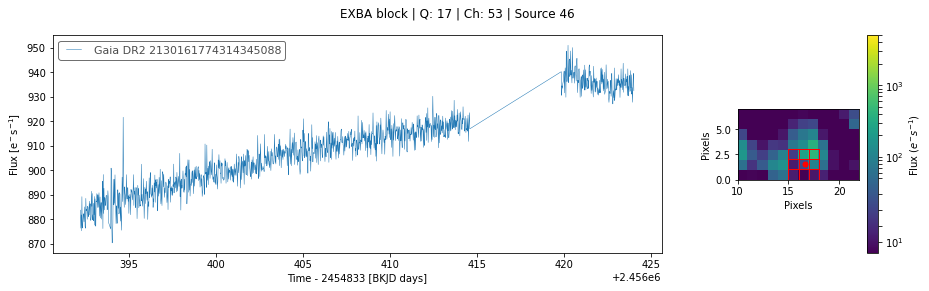

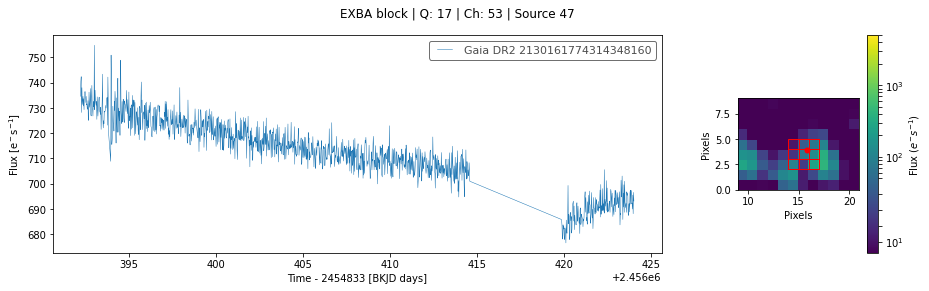

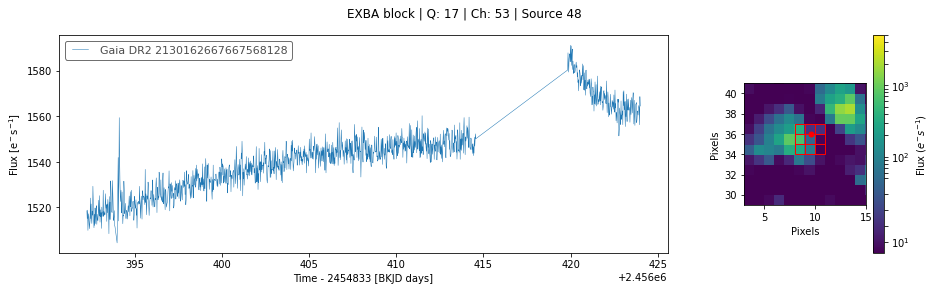

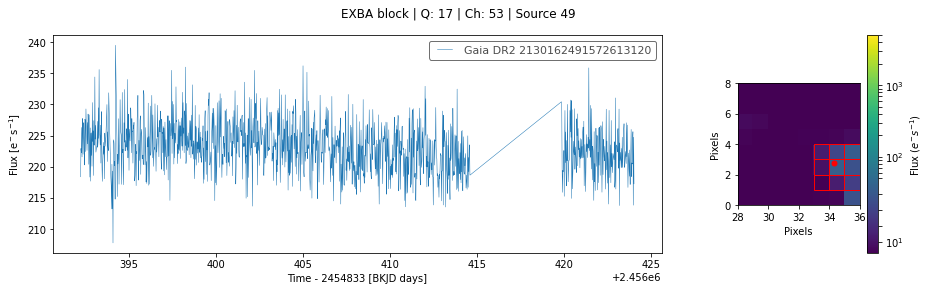

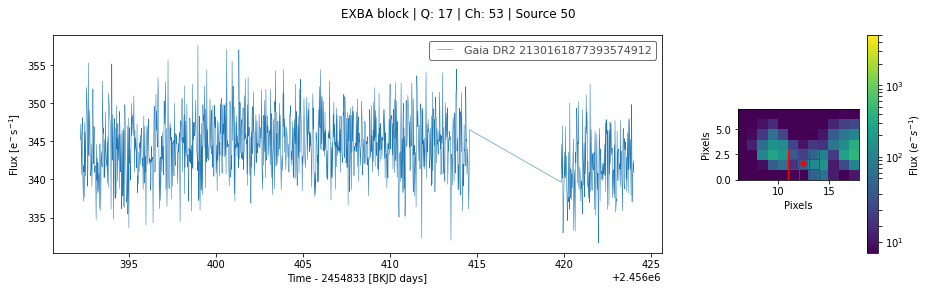

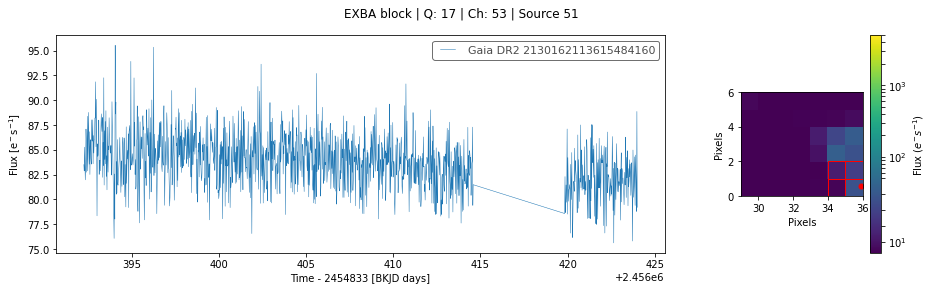

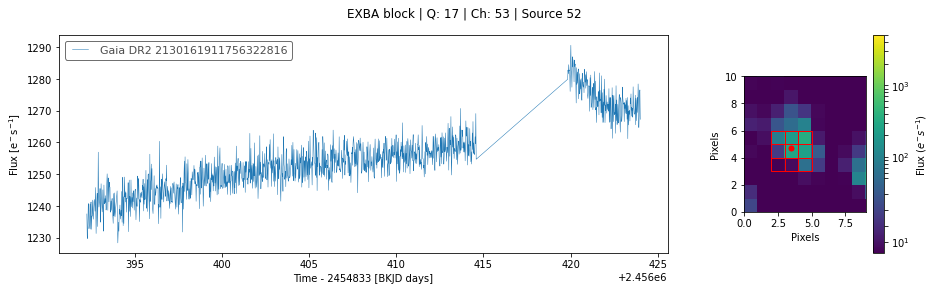

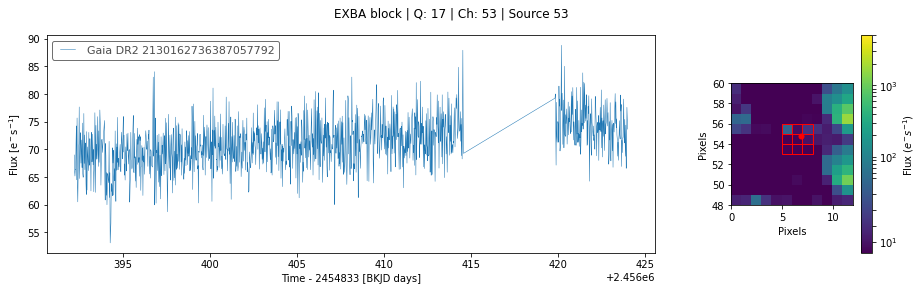

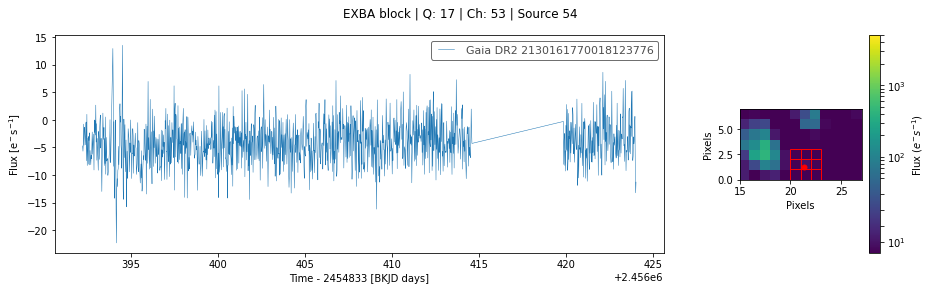

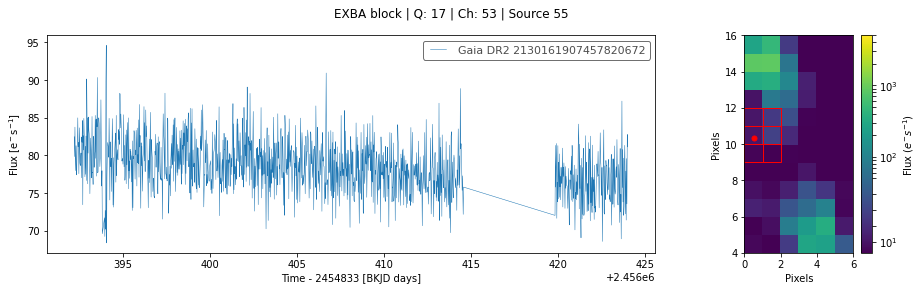

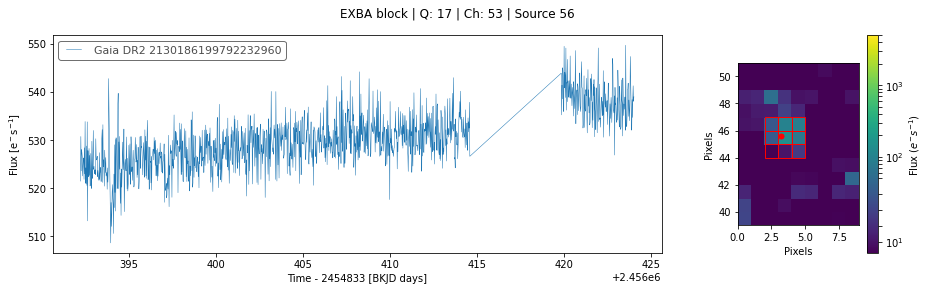

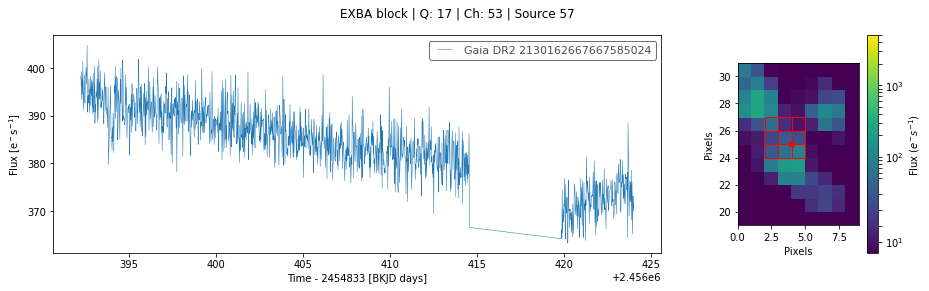

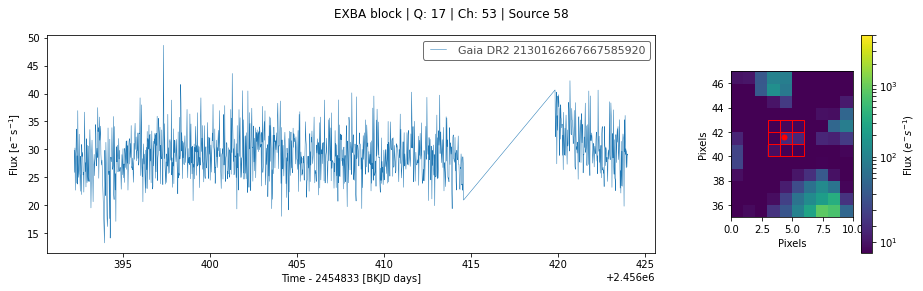

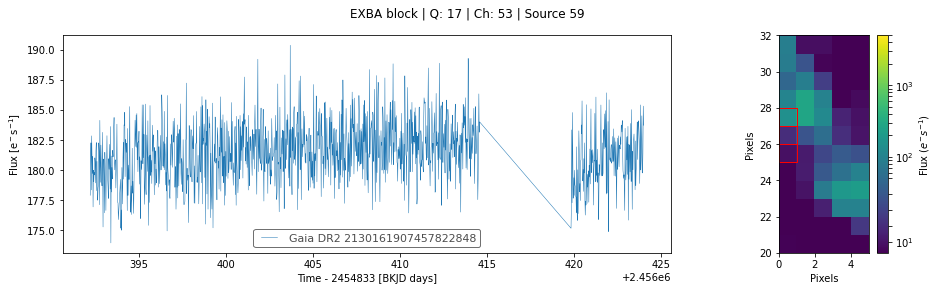

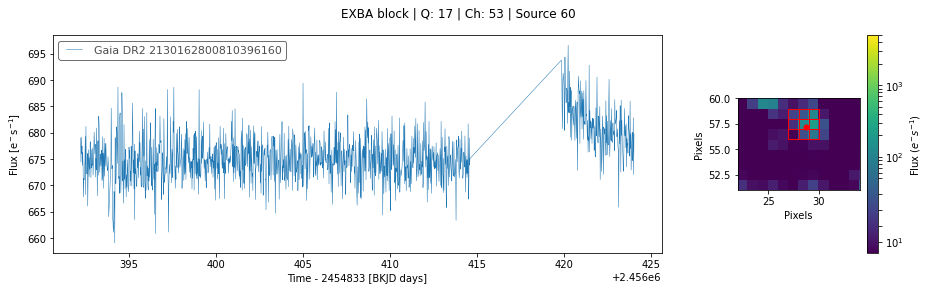

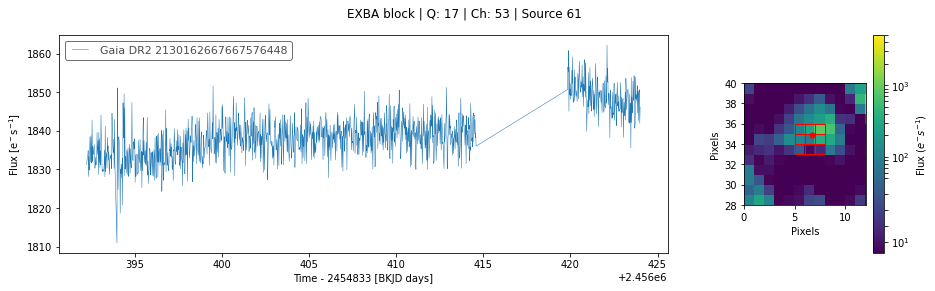

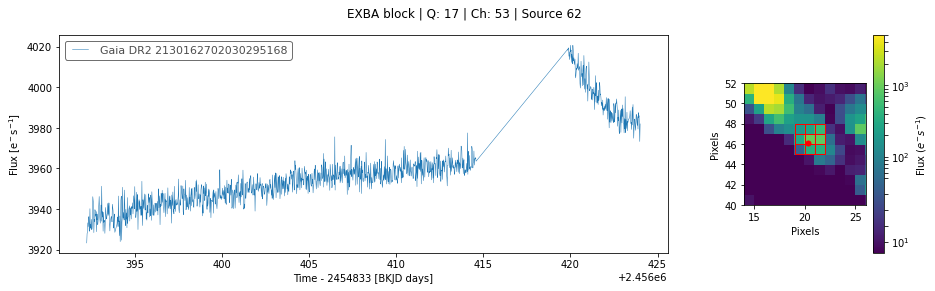

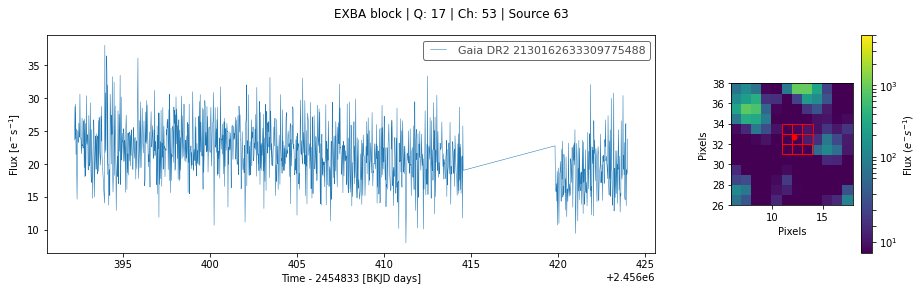

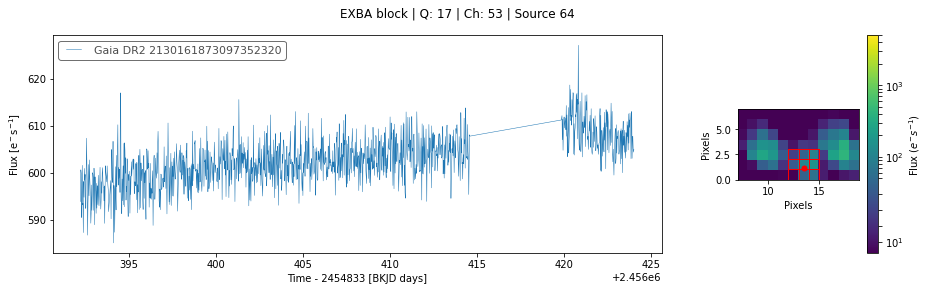

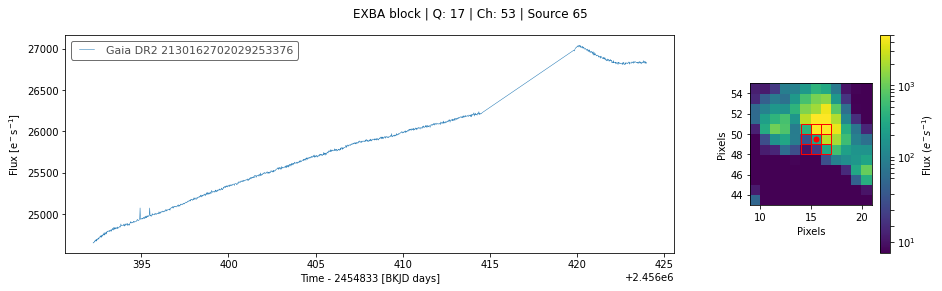

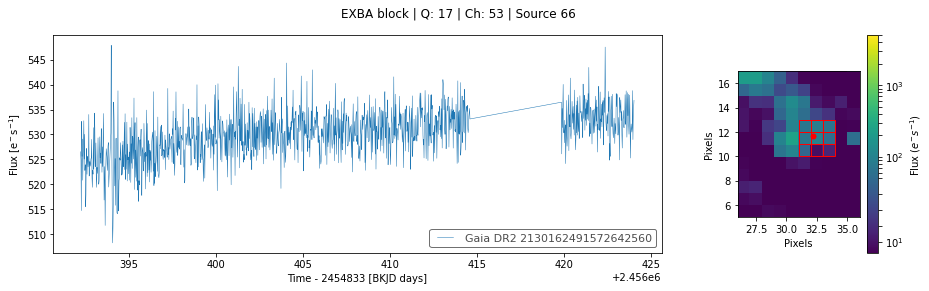

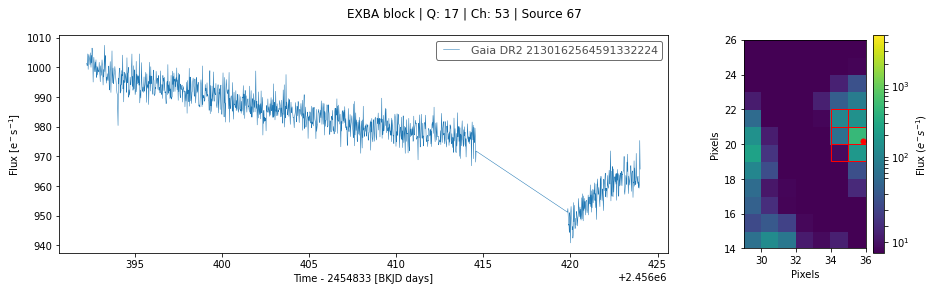

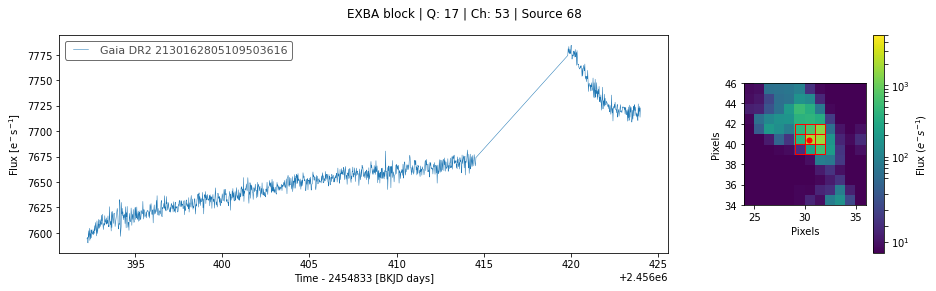

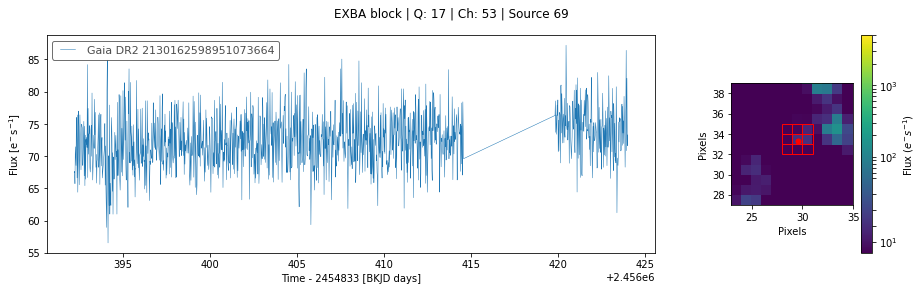

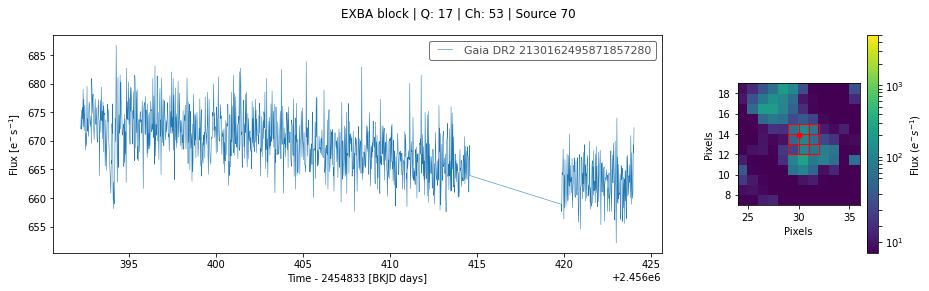

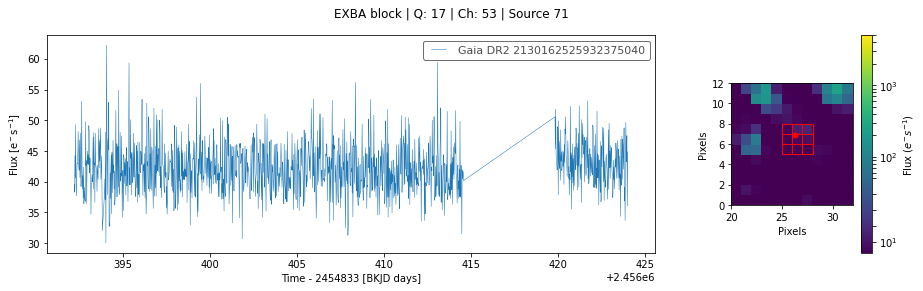

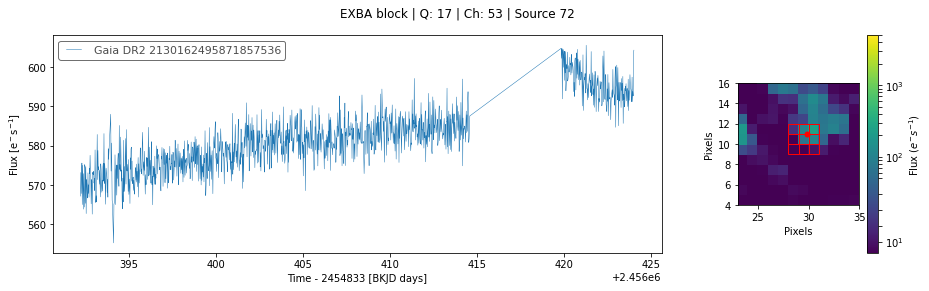

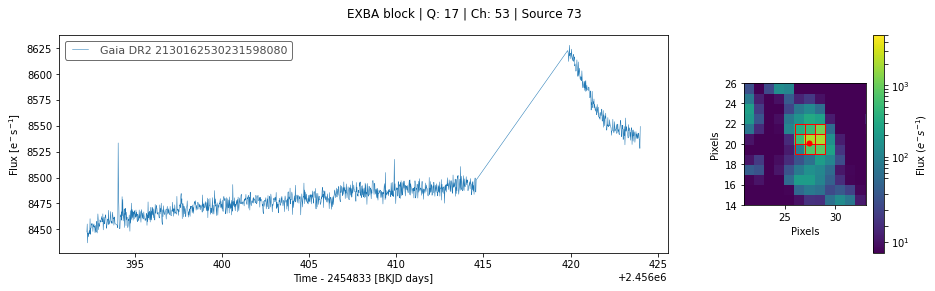

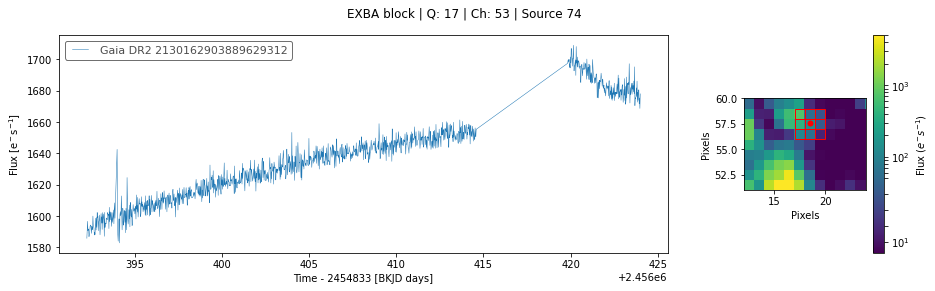

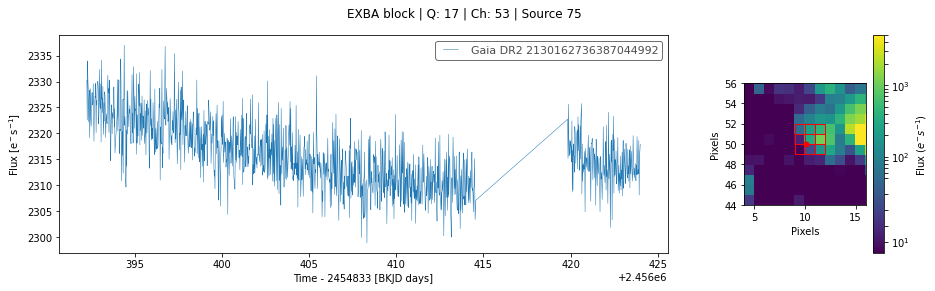

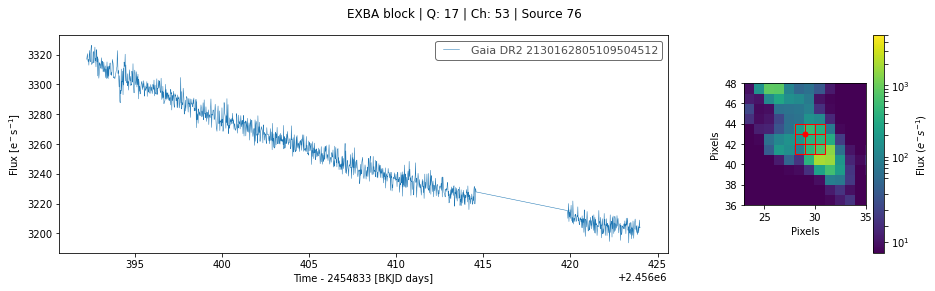

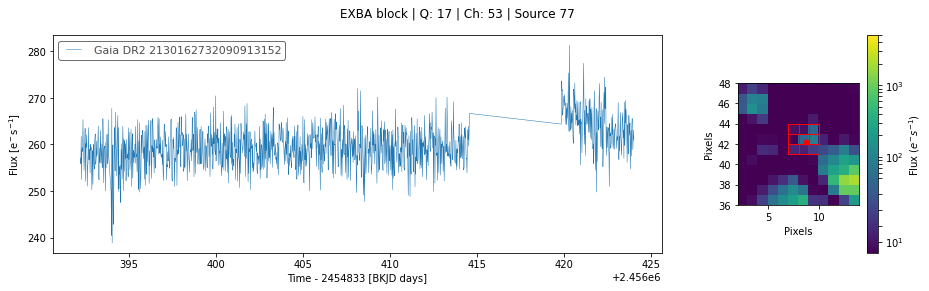

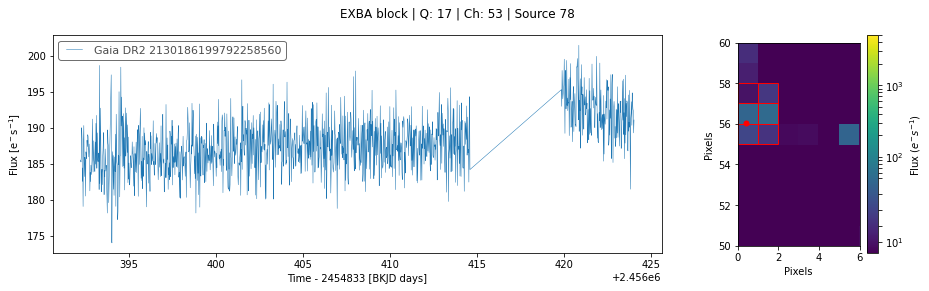

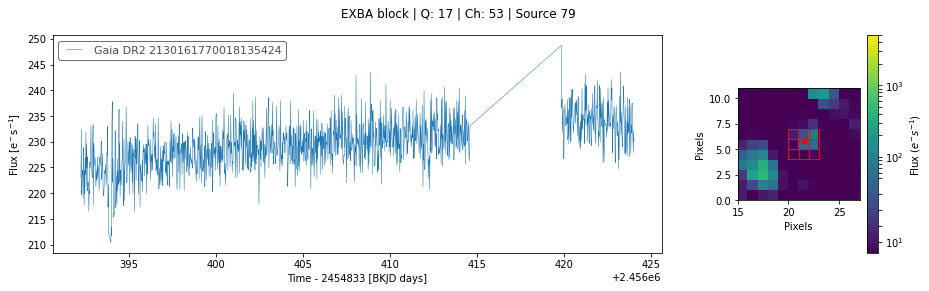

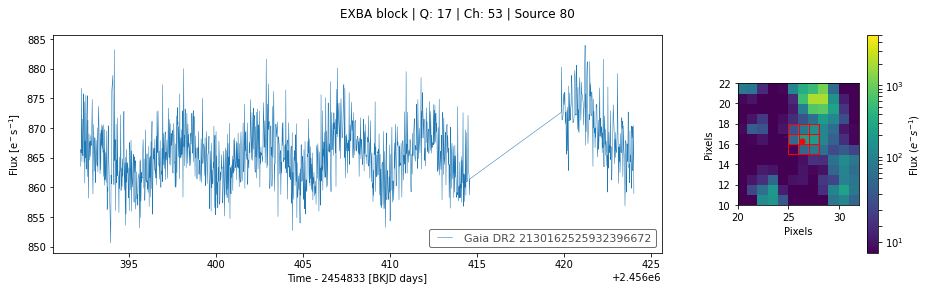

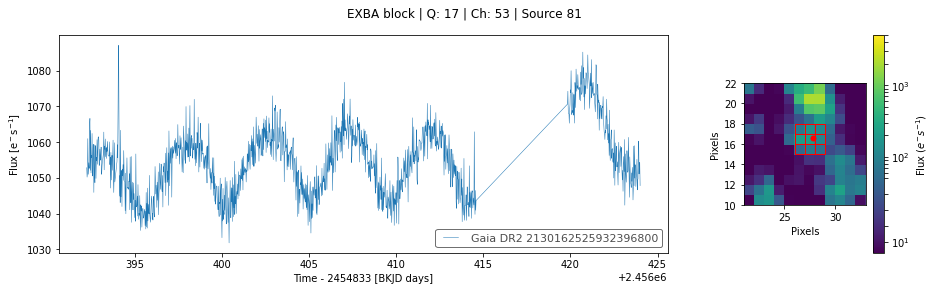

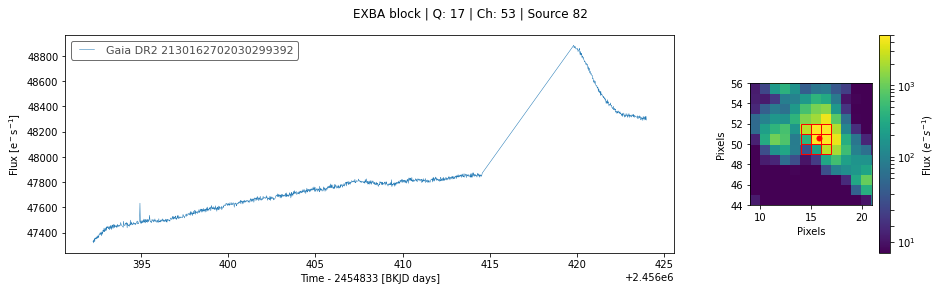

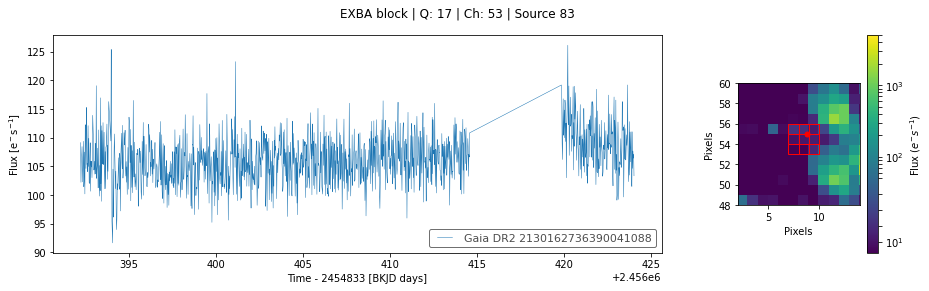

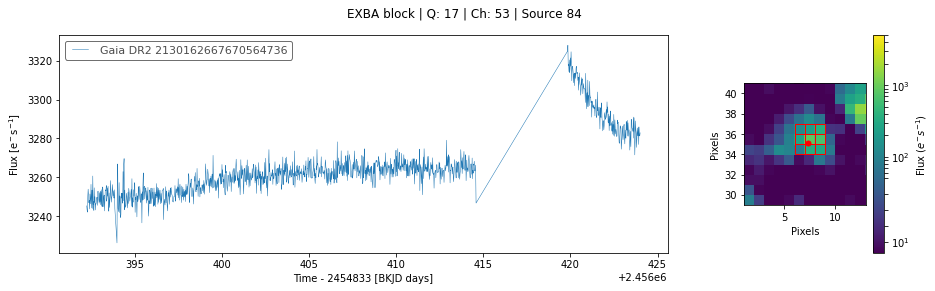

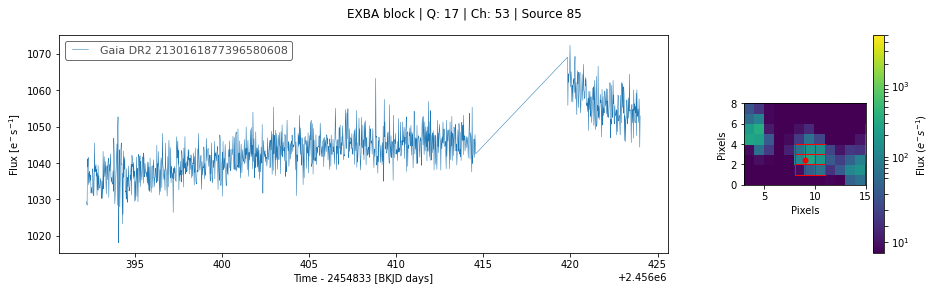

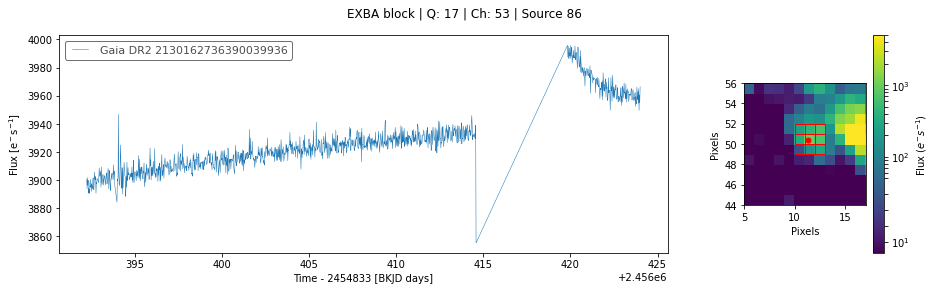

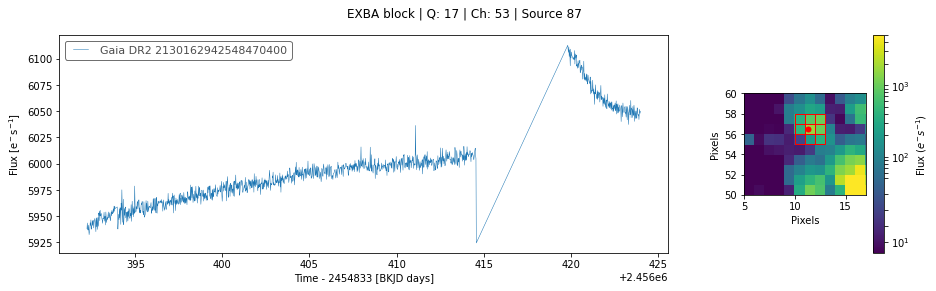

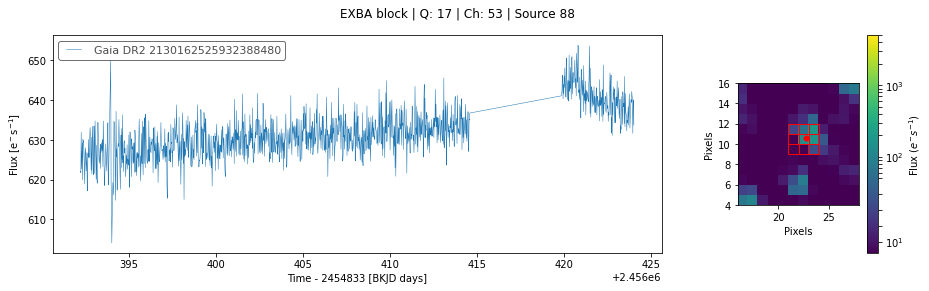

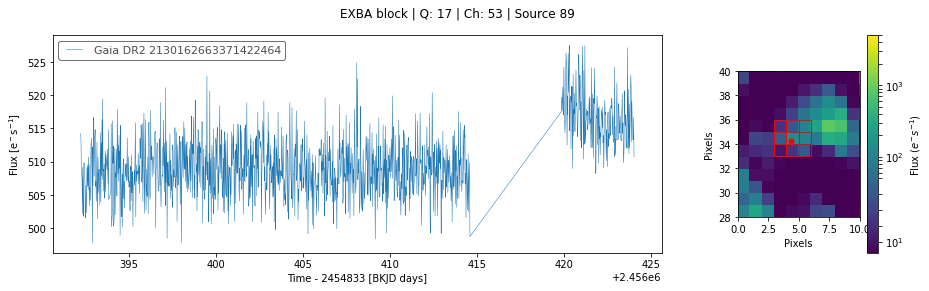

In [20]:
exba.plot_lightcurves(step=1)

In [80]:
lc = exba.sap_lcs[81]
print(lc.label)
cbvCorrector = CBVCorrector(lc)

Gaia DR2 2130162525932396800


<AxesSubplot:title={'center':'Kepler CBVs (Quarter.Module.Output : 5.16.1)'}, xlabel='Time [mjd]'>

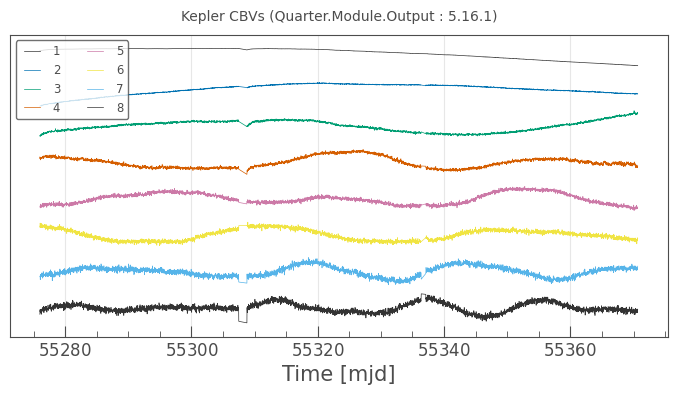

In [81]:
cbvCorrector.cbvs[0].plot([1,2,3,4,5,6,7,8])

Over fitting Metric: 0.8370259258913916
Under fitting Metric: 0.999438081721675


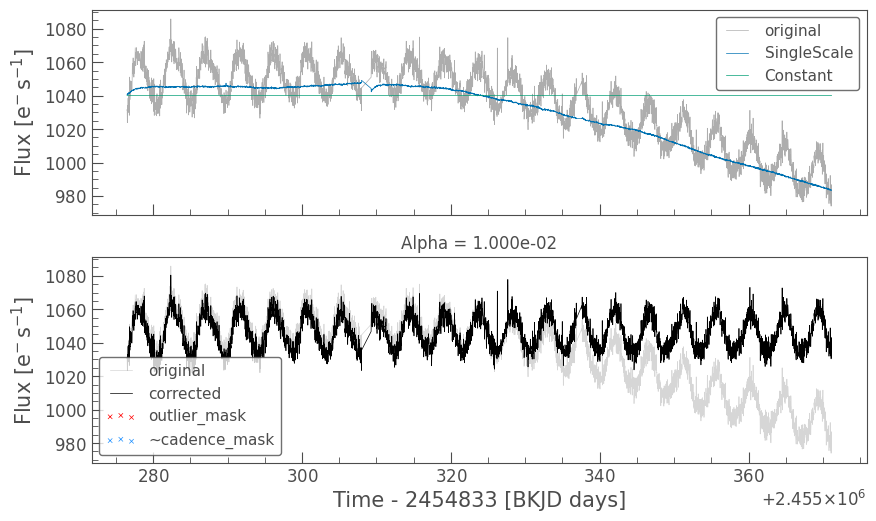

In [82]:
# Select which CBVs to use in the correction
cbv_type = ['SingleScale']
# Select which CBV indices to use
# Use the first 8 SingleScale and all Spike CBVS
cbv_indices = [np.arange(1,9)]
# Perform the correction
cbvCorrector.correct_gaussian_prior(cbv_type=cbv_type, cbv_indices=cbv_indices, alpha=1e-2)
cbvCorrector.diagnose();

# Note: this cell will be slow to run
print('Over fitting Metric: {}'.format(cbvCorrector.over_fitting_metric()))
print('Under fitting Metric: {}'.format(cbvCorrector.under_fitting_metric()))

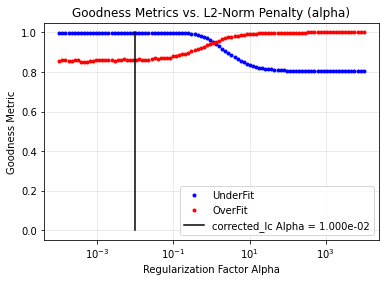

In [24]:
cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);

Optimized Over-fitting metric: 0.9344402092111826
Optimized Under-fitting metric: 0.9723424645610816
Optimized Alpha: 7.341e-01


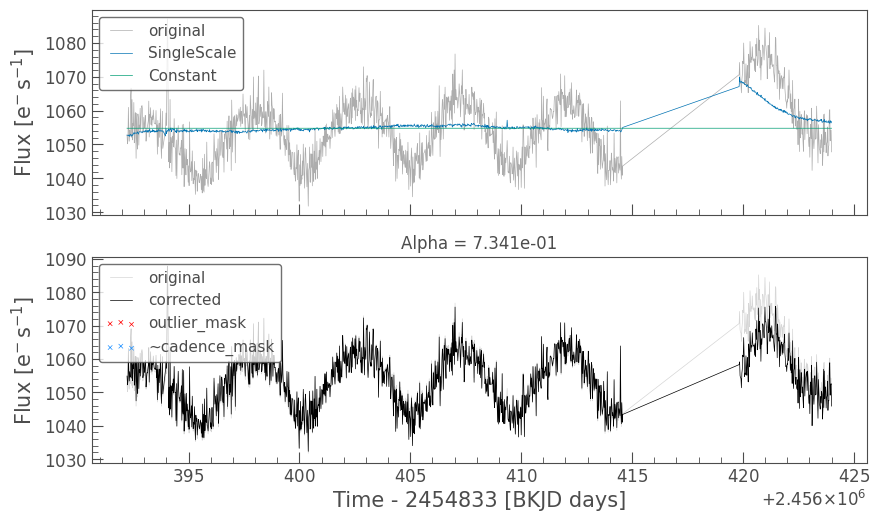

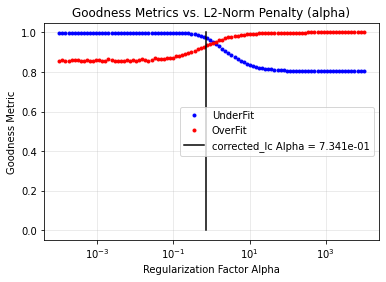

In [25]:
cbvCorrector.correct(cbv_type=cbv_type,
                     cbv_indices=cbv_indices, 
                     alpha_bounds=[1e-3, 1e3],
                     target_over_score=0.9,
                     target_under_score=0.8)
cbvCorrector.diagnose();
cbvCorrector.goodness_metric_scan_plot(cbv_type=cbv_type, cbv_indices=cbv_indices);

## Do BLS search

In [ ]:
exba.do_bls_search(plot=True)

### do it for known planets

In [98]:
planet_lc = lk.search_lightcurve('KIC 6922244', mission='Kepler',
                                 cadence='long').download_all()

BLS search:   0%|          | 0/5 [00:00<?, ?it/s]

No period specified. Using period at max power
No duration specified. Using duration at max power
No transit time specified. Using transit time at max power


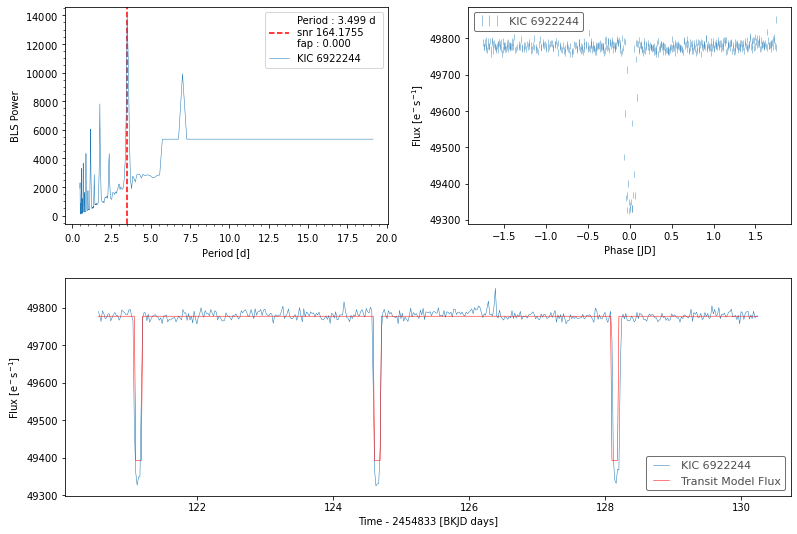

No period specified. Using period at max power
No duration specified. Using duration at max power
No transit time specified. Using transit time at max power


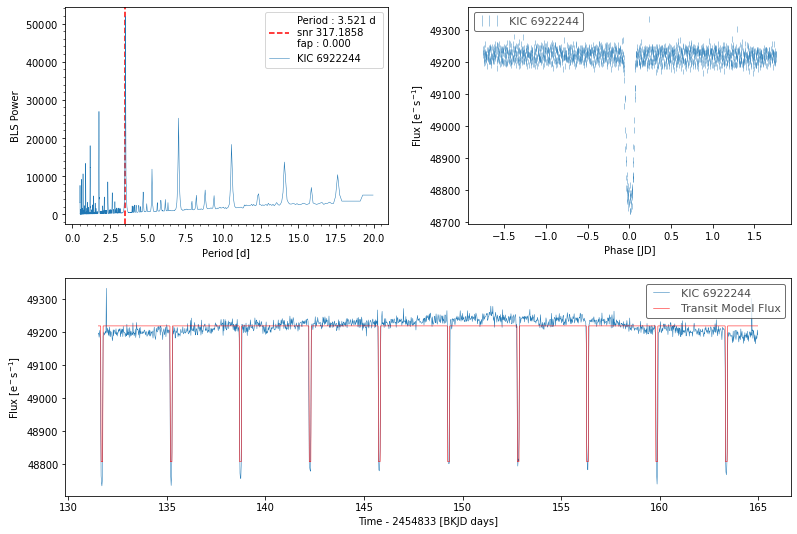

No period specified. Using period at max power
No duration specified. Using duration at max power
No transit time specified. Using transit time at max power


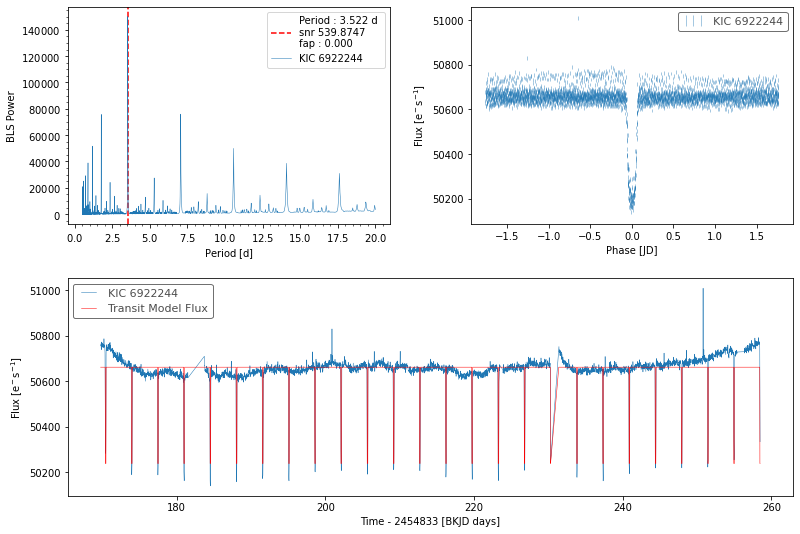

No period specified. Using period at max power
No duration specified. Using duration at max power
No transit time specified. Using transit time at max power


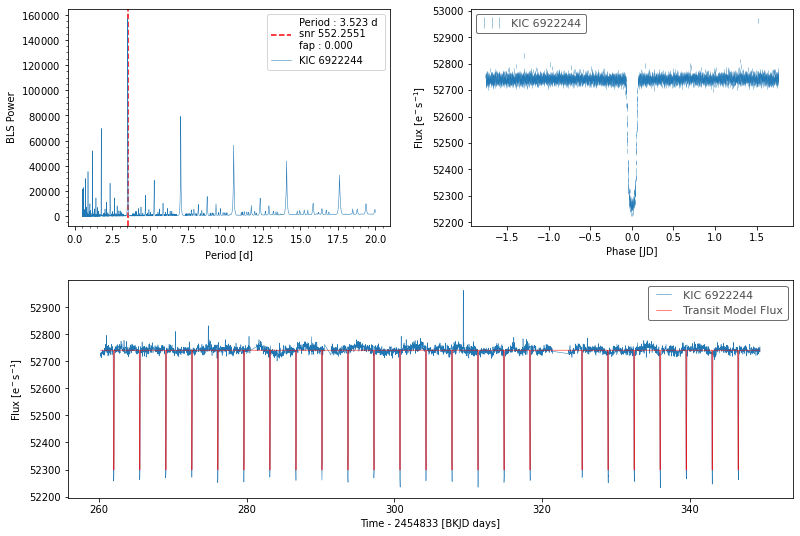

No period specified. Using period at max power
No duration specified. Using duration at max power
No transit time specified. Using transit time at max power


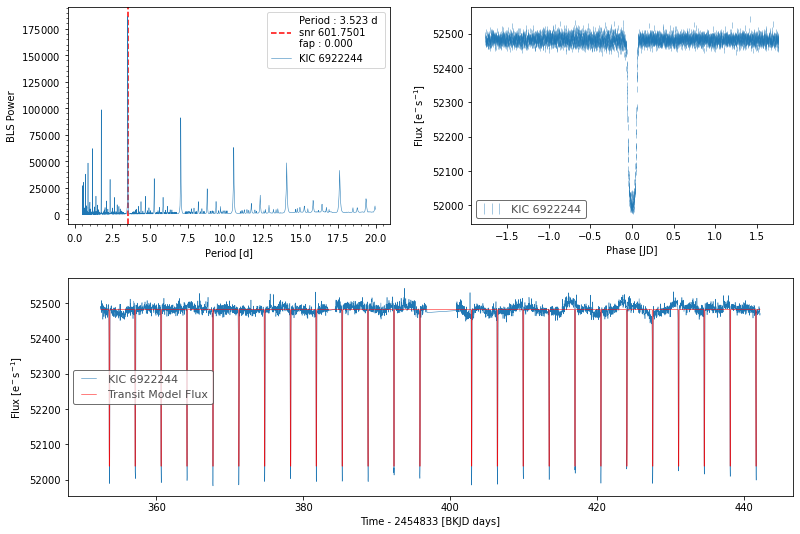

In [152]:
_, _ ,_ = exba.do_bls_search(plot=True, test_lcs=planet_lc[:5], n_boots=100)

In [191]:
planet_lc[5].remove_outliers(sigma_lower=20, sigma_upper=5).interact_bls()

In [190]:
planet_lc_stiched.interact_bls()